In [30]:

import os
import rasterio.plot
from rasterio.plot import show
import tensorflow as tf
import random
import cv2 as cv 
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import pandas as pd
import math 
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from mining_pages_utils.tensorflow_utils import run_vesselprofile_segmentation, readNoextensionImage, build_detectfn
from tensorflow import keras
import glob
from typing import List
from abc import ABCMeta, abstractmethod
import requests
from typing import Tuple
from mining_pages_utils.request_utils import addModifiedEntry

import datetime


from mining_pages_utils.request_utils import getListOfDBs
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from pathlib import Path
from descartes import PolygonPatch
from typing import Tuple
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib as mpl

mpl.use('Agg')
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
from IPython.display import display
import datetime
import numpy as np
from shutil import copyfile
import requests
import rasterio.mask
import json

In [3]:
def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        #return shapely.geometry.shape(shape)
        all_polygons.append(shapely.geometry.shape(shape))
        #print('What does the mask_10:layer give us?', shape, value)
        


    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    patch = PolygonPatch(all_polygons.buffer(0))
    fig, ax = plt.subplots()
    ax.add_patch(patch)
    ax.set_xlim(0, 1300)
    ax.set_ylim(0, 777)
    plt.show()
    return all_polygons

In [47]:
def polygons_to_mask(geodf, image_np):
    if 'geometry' in geodf.columns:
    
        #print('Polygonsto Mask Geometry is valid!')
        out_image = features.rasterize(geodf['geometry'], out_shape=(image_np.shape[0],image_np.shape[1]), default_value= 255)
        return out_image

In [49]:
def close_holes(series, smallerthanarea):
    """
    Close polygon holes by limitation to the exterior ring.
    Args:
        poly: Input shapely Polygon
    Example:
        df.geometry.apply(lambda p: close_holes(p))
    
    """
    exterior=Polygon(series['geometry'].exterior.coords)
    if series['geometry'].geom_type == 'Polygon':
        print('I am still a Polygon')
        if series['geometry'].interiors:
            largeinteriors = []
            for interior in series['geometry'].interiors:
                interior=Polygon(interior.coords)
                print('This is the interior areasize: ', interior.area)
                print('This is the smallerthanarea: ', smallerthanarea)
                if interior.area > smallerthanarea:
                    print('This interior will make a difference')
                    exterior = exterior.difference(interior)
    series['geometry']=exterior
    return series
        
   
 



In [6]:
def getarea(series):
    series['area']=series['geometry'].area
    print('This is the Area: ', series['area'])
    return series

In [7]:
def bufferpoly (series, buffer):
    series['geometry']=series['geometry'].buffer(buffer)
    return series

In [8]:
def multi2singlepolygon (multipolygons):
    listpolygons = []
    if multipolygons.geom_type == 'MultiPolygon':
        print('I am Multipolygon')
        # extract polygons out of multipolygon
        for polygon in multipolygons.geoms:
            if polygon.type == 'Polygon':
                exterior_coords = polygon.exterior.coords[:]
                interior_coords = []
                for interior in polygon.interiors:
                    interior_coords += interior.coords[:]
                print('This is the interiors of multi2single:', interior_coords)
            if polygon.geom_type == 'Polygon':
                print(vars(polygon))
                #print('But now I am not anymore or?', type(polygon))
                listpolygons.append(polygon)

    if multipolygons.geom_type == 'GeometryCollection':
        print('I am GeometryCollection')
        # extract polygons out of multipolygon
        for polygon in multipolygons.geoms:
            print('I am an elemnt of GeomCollection: ', polygon.geom_type)
            if polygon.geom_type == 'Polygon':
                print('But now I am not anymore or?', type(polygon))
                listpolygons.append(polygon)
    elif multipolygons.geom_type == 'Polygon':
        listpolygons.append(multipolygons)
    else:
        print('What kind of Geomerty are you? Answer: ',multipolygons.geom_type)
    


    return listpolygons

In [9]:
def multi2singlepolygon_df (gdf):
    newgdf = gpd.GeoDataFrame()
    for index, row in gdf.iterrows():

        if row['geometry'].geom_type == 'MultiPolygon':
            print('I am Multipolygon')
            # extract polygons out of multipolygon
            for polygon in row['geometry'].geoms:
                if polygon.type == 'Polygon':
                    exterior_coords = polygon.exterior.coords[:]
                    interior_coords = []
                    for interior in polygon.interiors:
                        interior_coords += interior.coords[:]
                    print('This is the interiors of multi2single:', interior_coords)
                if polygon.geom_type == 'Polygon':
                    print(vars(polygon))
                    #print('But now I am not anymore or?', type(polygon))
                    singlepolyrow = row
                    singlepolyrow['geometry']=polygon
                    newgdf = newgdf.append(singlepolyrow)

        if row['geometry'].geom_type == 'GeometryCollection':
            print('I am GeometryCollection')
            # extract polygons out of multipolygon
            for polygon in row['geometry'].geoms:
                print('I am an elemnt of GeomCollection: ', polygon.geom_type)
                if polygon.geom_type == 'Polygon':
                    print('But now I am not anymore or?', type(polygon))
                    singlepolyrow = row
                    singlepolyrow['geometry']=polygon
                    newgdf = newgdf.append(singlepolyrow)
        elif row['geometry'].geom_type == 'Polygon':
            singlepolyrow = row
            singlepolyrow['geometry']=row['geometry']
            newgdf = newgdf.append(singlepolyrow)
        else:
            print('What kind of Geomerty are you? Answer: ',row['geometry'].geom_type)
    


    return newgdf

In [10]:
def simplify(series, d, cf):
    print('Simplify tolerance distance and cf: ', d, cf)
    series['geometry'] = series['geometry'].buffer(-d).buffer(d*cf).intersection(series['geometry']).simplify(d)
   
    return series
    

In [11]:
def filterintersects(tobefilteredgdf, referencegdf, largerthanthis):
    filteredgdf = gpd.GeoDataFrame()
    for index, targetrow in tobefilteredgdf.iterrows():
        for index, referencerow in referencegdf.iterrows():
            if targetrow['geometry'].intersects(referencerow['geometry']) or targetrow['geometry'].area > largerthanthis :
                filteredgdf = filteredgdf.append(targetrow)
    return filteredgdf
    

In [45]:
def process_files(vessel):
    print(vessel)
    image_np = readNoextensionImage(vessel)
    print(type(image_np))
    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]
    detections = miningfiguresdetectfn(input_tensor)
    image_np_with_detections = image_np.copy()
    empty_with_detections = np.zeros((image_np.shape[0], image_np.shape[1], image_np.shape[2])).astype(np.uint8)
    
    #num_detections = int(output_dict.pop('num_detections'))
    #print(num_detections)
    # The following processing is only for single image
    detection_boxes = tf.squeeze(detections['detection_boxes'], [0])
    detection_masks = tf.squeeze(detections['detection_masks'], [0])
    #print(detection_boxes)
    
    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    real_num_detection = tf.cast(detections['num_detections'][0], tf.int32)
    detection_boxes = tf.slice(detection_boxes, [0, 0],
                            [real_num_detection, -1])
    #print('detection_boxes', detection_boxes)
    detection_masks = tf.slice(detection_masks, [0, 0, 0],
                            [real_num_detection, -1, -1])
    #print('detection_masks', detection_masks)
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
        detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
    detection_masks_reframed = tf.cast(
        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
    # Follow the convention by adding back the batch dimension
    detections['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)

    detections['num_detections'] = int(detections['num_detections'][0])
    detections['detection_classes'] = detections['detection_classes'][0].numpy(
    ).astype(np.uint8)
    detections['detection_boxes'] = detections['detection_boxes'][0].numpy()
    detections['detection_scores'] = detections['detection_scores'][0].numpy()
    detections['detection_masks'] = detections['detection_masks'][0].numpy()

    #print(detections['detection_scores'])
    #print('image-size: ',image_np.shape)
    #print('mask-size: ',detections['detection_masks'].shape)


 



    vis_util.visualize_boxes_and_labels_on_image_array(
        empty_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'],
        detections['detection_scores'],
        category_index,
        instance_masks=detections['detection_masks'],
        use_normalized_coordinates=True,
        max_boxes_to_draw=3,
        min_score_thresh=.1,
        mask_alpha=1,
        skip_boxes=True,
        skip_scores= True,
        skip_labels=True)


    
    mask = empty_with_detections[:,:,:1]
    
    print('CountNonZero:', cv.countNonZero(mask))
    if not cv.countNonZero(mask) == 0 :
        detectedmask = mask.astype(np.uint8)
        print('any smalle than 255')
        mask = mask.astype(np.uint8)
        
        kernelwidth = int(image_np.shape[0] * image_np.shape[1] / 4000)
        kernelheight = int(image_np.shape[0] * image_np.shape[1] / 2000)
        kernel = np.ones((kernelheight,kernelwidth),np.uint8)
        
        print('firstkernel',kernel.shape)
        mask = cv.dilate(mask,kernel,iterations = 1)
        kernelwidth = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 50)
        kernelheight = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 50)
        kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        print('This is the Kernel to erode the detectedmask: ', kernel.shape)
        detectedmask = cv.erode(detectedmask,kernel,iterations = 1)


        mask[mask > 0] = cv.GC_PR_FGD
        mask[mask == 0] = cv.GC_BGD
        fgModel = np.zeros((1, 65), dtype="float")
        bgModel = np.zeros((1, 65), dtype="float")
        (mask, bgModel, fgModel) = cv.grabCut(image_np, mask, None, bgModel,fgModel, 10, mode=cv.GC_INIT_WITH_MASK)
        values = (
            ("Definite Background", cv.GC_BGD),
            ("Probable Background", cv.GC_PR_BGD),
            ("Definite Foreground", cv.GC_FGD),
            ("Probable Foreground", cv.GC_PR_FGD),
        )
        
        valuemask = (mask == cv.GC_PR_FGD).astype("uint8") * 255
        detectedmask = detectedmask.astype("uint8") * 255
        valuemask = cv.addWeighted(detectedmask, 0.5, valuemask, 0.5, 0.0)

        plt.imshow(detectedmask)
        plt.show()
        print(detectedmask.shape)
        plt.imshow(valuemask)
        plt.show()
        print(valuemask.shape)
        kernelwidth = int(image_np.shape[0] * image_np.shape[1] / 80000)
        kernelheight = int(image_np.shape[0] * image_np.shape[1] / 80000)
        kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        #valuemask = cv.dilate(valuemask,kernel,iterations = 1)
        multipolygons = mask_to_polygons_layer(valuemask)
        #print('This is the length of mask_to_polygons resullt (grabcut): ', multipolygons)
        detectedmask_polys = mask_to_polygons_layer(detectedmask)

        
        print('Here comes grabcut multi2single:')
        listpolygons = multi2singlepolygon(multipolygons)
        print('This is the length of multi2singlepolygon resullt (grabcut): ', len(listpolygons))
        print('Here comes detected multi2single:')
        detected_listpolygons = multi2singlepolygon(detectedmask_polys)

        
        detectedpolygons = [{'geometry':polygon, 'method':'detected'} for polygon in detected_listpolygons]
        print(detectedpolygons)
        detecteddf = pd.DataFrame(detectedpolygons)
        detectedgdf = gpd.GeoDataFrame(detecteddf, geometry='geometry')        

        #listpolygons = list(multipolygons.geoms)
        polygons = [{'geometry':polygon, 'method':'grabcut'} for polygon in listpolygons]
        
        df = pd.DataFrame(polygons)
        gdf = gpd.GeoDataFrame(df, geometry='geometry')
        gdf.plot()
        print('This is before close_holes:')
        plt.show()
        gdf = gdf.apply(close_holes, smallerthanarea=int(image_np.shape[0] * image_np.shape[1] / 1000), axis=1)
        #buffer = -image_np.shape[0] * image_np.shape[1] / 160000
        #gdf = gdf.apply(bufferpoly, buffer=buffer, axis=1)
        gdf.plot()
        print('This is after close_holes:')
        plt.show()        
        gdf=gdf.apply(getarea, axis=1)
        gdfmax= gdf.nlargest(5, 'area', keep='first')

        #print ('tolerance=', str(image_np.shape[0] * image_np.shape[1] / 160000))
        #gdfmax = gdfmax.apply(simplify, d=1.5, cf=1.6, axis=1)
        buffer = -int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 200)
        print('This is the Buffer ',buffer)
        gdfmax = gdfmax.apply(bufferpoly, buffer=buffer, axis=1)
        buffer = int(math.sqrt(image_np.shape[0] * image_np.shape[1]) / 200)
        gdfmax = gdfmax.apply(bufferpoly, buffer=buffer, axis=1)
        gdfmax = multi2singlepolygon_df(gdfmax)
        gdfmax=gdfmax.apply(getarea, axis=1)
        print('Only larger than this survives:', int(image_np.shape[0] * image_np.shape[1] / 300))
        gdfmax=gdfmax[gdfmax['area'] > int(image_np.shape[0] * image_np.shape[1] / 300)]
        gdfmax = gdfmax.apply(close_holes, smallerthanarea=int(image_np.shape[0] * image_np.shape[1] / 1000), axis=1)
        gdfmax=gdfmax.apply(getarea, axis=1)
        print(gdfmax)
        if not gdfmax.empty and 'geometry' in gdfmax.columns:
            gdfmax = filterintersects(gdfmax, detectedgdf, largerthanthis=max(gdfmax['area'])/30)
       


            #gpd.GeoDataFrame(gdf, geometry='geometry')
            

            transform = from_origin(0, 0, 1, 1)

            image_raster = rasterio.open(vessel, 'r', driver='PNG',transform=transform)
            #gdfmax = gpd.GeoDataFrame(gdfmax, geometry='geometry')

        
            #rasterio.plot.show((image_raster, 1))
            out_image = polygons_to_mask(gdfmax, empty_with_detections)
            show(out_image)
            plt.show()
            original_img = Image.fromarray(image_np)
            segimage = out_image
            #max(multipolygon, key=lambda a: a.area)
            fig, ax = plt.subplots(figsize=(15,15))
            rasterio.plot.show(image_raster, ax=ax)
            gdfmax.plot(ax=ax, facecolor='none', edgecolor='red')
            detectedgdf.plot(ax=ax, facecolor='none', edgecolor='green')
            #show(ax)
            
            plt.show()#
            return original_img, segimage



        #print(type(polygons))
        
        #show(out_image)
        #plt.show()

        #kernelwidth = int(image_np.shape[0] / 120)
        #kernelheight = int(image_np.shape[1] / 120)
        #kernel = np.ones((kernelwidth,kernelheight),np.uint8)
        #mask = cv.erode(mask,kernel,iterations = 1)

        #plt.figure()
        #plt.imshow(valuemask)
        #plt.show()
	
    #ret,thresh1 = cv.threshold(gray,127,255,cv.THRESH_BINARY)
    #(mask, bgModel, fgModel) = cv.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount[, mode])  


    #pil_mask = Image.fromarray(np.uint8(255.0*0.4*(detections['detection_masks'] > 0))).convert('L')
    #pil_mask = pil_image.convert('RGB')
    #np.copyto(image, np.array(pil_image.convert('RGB')))
    #segmented_img = Image.fromarray(pil_mask)

    

        

In [39]:
def createVOCfolder (outputpath, taskname,labelmappath):
    originals = taskname + '_originals'
    originalimagesfolder = outputpath / originals
    taskfolder = outputpath / taskname
    targetlabelmappath = taskfolder / 'labelmap.txt'
    imagesetfolder = taskfolder / 'ImageSets'
    imagesetsegmentationfolder = imagesetfolder / 'Segmentation'
    subsettextfile = imagesetsegmentationfolder / 'train.txt'
    segmentclassfolder = taskfolder / 'SegmentationClass'
    segmentobjectfolder = taskfolder / 'SegmentationObjekt' 
    print(taskfolder)
    taskfolder.mkdir(parents=True, exist_ok=True)
    originalimagesfolder.mkdir(parents=True, exist_ok=True)
    segmentclassfolder.mkdir(parents=True, exist_ok=True)
    segmentobjectfolder.mkdir(parents=True, exist_ok=True)
    imagesetfolder.mkdir(parents=True, exist_ok=True)
    imagesetsegmentationfolder.mkdir(parents=True, exist_ok=True)
    with open(subsettextfile, 'w') as fp:
        pass
    
    copyfile(labelmappath, targetlabelmappath)
    return originalimagesfolder, taskfolder, subsettextfile, segmentclassfolder, segmentobjectfolder

In [40]:
def addToVOCfolder (original_img, segmented_img):

    #pil_mask = pil_image.convert('RGB')
    #np.copyto(image, np.array(pil_image.convert('RGB')))
    vesselbasename = os.path.basename(vessel) + '.png'
    print('This is the segmented image:' , segmented_img.shape, type(segmented_img))
    segmented_img = Image.fromarray(segmented_img)
    segmented_img.save(os.path.join(segmentclassfolder, vesselbasename), format='png')
    original_img.save(os.path.join(originalimagesfolder, vesselbasename), format='png')
    
    with subsettextfile.open('a+') as f:
        f.write(os.path.basename(vessel) + "\n")
    
    

In [15]:
def selectimages(amount ):

    vessel_image_list = [ os.path.join(data_path, i) for i in random.sample(os.listdir(data_path), amount)]
    #print(vessel_image_list)
    return vessel_image_list

In [16]:
def fourier_featurevector_to_db (segmented_img, drawingID, db_url, db_name, auth, fd_harmonics = 20):



    pouchDB_url = f'{db_url}/{db_name}'

    descriptor_generator = FourierDescriptorPhase(segmented_img, fd_harmonics)
    with tqdm(total=len(descriptor_generator)) as pbar:
        for feature in descriptor_generator:
            put_data_in_pouchdb(pouchDB_url, drawingID,
                                auth=auth, feature=feature, feature_type='phaseFourier')
            pbar.update(1)

In [17]:
class FeatureEntry(List):
    List[float]

In [18]:
class ResnetFeatureVectors:
    """
    @brief: Data generator to return feature vector of given keras model
    @param images_path: location of source images
    @param model: path to keras Model
    @param image: size to rescale images to
    """

    def __init__(self, model: keras.Model, segmented_img: np.ndarray, image_size: Tuple[int, int] = (512, 512)) -> None:
        self._model = model
        self._segmented_img = segmented_img
        self._image_size = image_size

    def __iter__(self) -> FeatureEntry:
        img = cv.resize(self._segmented_img, self._image_size)
        feature_vec = self._model.predict(
            img[np.newaxis, ...], verbose=False)
        yield FeatureEntry(feature_vec.flatten().tolist())

In [19]:
def compute_resnet_featurevector(segmented_img):
    model = keras.applications.resnet50.ResNet50(
        include_top=False, pooling='avg', weights='imagenet')
    vector_generator = ResnetFeatureVectors(segmented_img, model)
    return vector_generator


In [20]:
class ProvideListOfStr(Exception):
    pass


class FourierDescriptorBase(metaclass=ABCMeta):
    """
    Base class to construct Fourier descriptor of given binary images \n
    @param list of filenames
    @param normalize set if Fourier descriptors should be normalized
    @param descriptor_harmonics number of fourier descriptor (FD) harmonics -> FD[-m_n, -m_n-1, ...-m_1, m_0, m_1, ...., m_n-1, m_n ] for n harmonics
    """

    def __init__(self, image_path: str, descriptor_harmonics: int, normalize: bool = True):
        self.descriptors = []
        self.contours = []
        self.descriptor_harmonics = descriptor_harmonics
        self._normalize = normalize
        if isinstance(image_path, str):
            print(image_path)
            self.images = glob.glob(f"{image_path}/*.png")
        else:
            raise ProvideListOfStr

    def __iter__(self) -> FeatureEntry:
        for img_name in self.images:
            image = cv.imread(img_name, cv.IMREAD_GRAYSCALE)
            resource_id = self._resourceId_from_file(img_name)

            if self.is_image_black(image):
                yield FeatureEntry(resource_id, [0]*self.getDescriptorDimensions())
                continue

            self.contours.append(
                self.detectOutlineContour(image.astype('uint8')))
            unnormalized_descriptor = self.makeFourierDescriptorFromPolygon(
                self.contours[-1][:, 0], self.contours[-1][:, 1], self.descriptor_harmonics)
            if self._normalize:
                yield FeatureEntry(resource_id, self.normalizeDescriptor(unnormalized_descriptor).tolist())
            else:
                yield FeatureEntry(resource_id, unnormalized_descriptor.tolist())

    def __len__(self) -> int:
        return len(self.images)

    def detectOutlineContour(self, bin_image: np.ndarray) -> np.ndarray:
        """ Detects outline contour of given binary image """
        contours, _ = cv.findContours(
            bin_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        return self.getLargestContour(contours)

    def makeFourierDescriptor_basic(self, contour: List):
        """ calculates the (unnormalized!) fourier descriptor from a list of points """
        contour_complex = np.empty(contour.shape[:-1], dtype=complex)
        contour_complex.real = contour[:, 0]
        contour_complex.imag = contour[:, 1]
        return np.fft.fft(contour_complex)

    @abstractmethod
    def normalizeDescriptor(self, descriptor: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def getDescriptorDimensions(self) -> int:
        pass

    def getLargestContour(self, contours: List) -> np.ndarray:
        """ Returns the largest contour of a list of contours. 
            Makes sure that contours created of noisy image artifacts are not returned
        """
        contours = sorted(contours, key=len, reverse=True)
        return np.array(contours[0][:, 0, :])

    def makeFourierDescriptorFromPolygon(self, X: List, Y: List, harmonics: int = 40) -> np.ndarray:
        """ @brief  Compute the Fourier Descriptors for a polygon.
                    Implements Kuhl and Giardina method of computing the coefficients
                    for a specified number of harmonics. See the original paper for more detail:
                    Kuhl, FP and Giardina, CR (1982). Elliptic Fourier features of a closed
                    contour. Computer graphics and image processing, 18(3), 236-258.
                    Or see W. Burger et. al. - Principles of Digital Image Processing - Advanced Methods
            @param X (list): A list (or numpy array) of x coordinate values.
            @param Y (list): A list (or numpy array) of y coordinate values.
            @param harmonics (int): The number of harmonics to compute for the given
                    shape, defaults to 10.
            @return numpy.ndarray: A complex numpy array of shape (harmonics, ) representing the unnormalized Fourier descriptor 
        """
        new_vector_length = 2*harmonics+1
        FD = np.zeros(new_vector_length)+1j*np.zeros(new_vector_length)

        contour = np.array([(x, y) for x, y in zip(X, Y)])

        N = len(contour)
        dxy = np.array([contour[(i+1) % N] - contour[i]for i in range(N)])
        dt = np.sqrt((dxy ** 2).sum(axis=1))
        t = np.concatenate([([0, ]), np.cumsum(dt)])
        T = t[-1]

        # compute coefficient G(0)
        a0 = 0
        c0 = 0
        for i in range(len(contour)):
            s = (t[i+1]**2 - t[i]**2)/(2*dt[i]) - t[i]
            a0 += s*dxy[i, 0] + dt[i]*(X[i]-X[0])
            c0 += s*dxy[i, 1] + dt[i]*(Y[i]-Y[0])
        FD[0] = np.complex(X[0] + T**-1*a0, Y[0] + T**-1*c0)

        # compute remaining coefficients
        for m in range(1, harmonics+1):
            omega0 = (2*np.pi*m)/T * np.array([t[i]
                                               for i in range(len(contour))])  # t
            omega1 = (
                2*np.pi*m)/T * np.array([t[(i+1) % len(contour)] for i in range(len(contour))])

            a_m = np.sum((np.cos(omega1) - np.cos(omega0)) / dt * dxy[:, 0])
            c_m = np.sum((np.cos(omega1) - np.cos(omega0)) / dt * dxy[:, 1])

            b_m = np.sum((np.sin(omega1) - np.sin(omega0)) / dt * dxy[:, 0])
            d_m = np.sum((np.sin(omega1) - np.sin(omega0)) / dt * dxy[:, 1])

            const = T/(2*np.pi*m)**2
            FD[m] = const * np.complex(a_m+d_m, c_m - b_m)
            FD[-m % new_vector_length] = const * \
                np.complex(a_m - d_m, c_m + b_m)

        return FD

    def is_image_black(self, image: np.ndarray) -> bool:
        return True if cv.countNonZero(image) == 0 else False

    def _resourceId_from_file(self, filename: str) -> str:
        return Path(filename).stem


In [21]:
class FourierDescriptorPhase(FourierDescriptorBase):
    """
    Class to construct phase preserving Fourier descriptor of given binary images \n
    @param list of filenames or list of images
    @param number of fourier descriptor (FD) harmonics -> FD[-m_n, -m_n-1, ...-m_1, m_0, m_1, ...., m_n-1, m_n ] for n harmonics
    @return pair of Fourier descriptors G1 and G2
    """

    def normalizeDescriptor(self, descriptor: np.ndarray) -> np.ndarray:
        self._setTranslationInvariant(descriptor)
        self._setScaleInvariant(descriptor)
        G_a, G_b = self._setStartPointInvariant(descriptor)

        # rotation

        G_ac = np.concatenate((G_a.real, G_a.imag))
        G_bc = np.concatenate((G_b.real, G_b.imag))
        complex_vector = np.concatenate((G_ac, G_bc))

        return complex_vector.real + complex_vector.imag

    def _setTranslationInvariant(self, descriptor: np.ndarray):
        """
        @brief Makes given descriptor translation invariant
        @param descriptor Fourier descriptor
        """
        descriptor[0] = 0

    def _setScaleInvariant(self, descriptor: np.ndarray):
        """
        @brief Makes given descriptor scale invariant
        @param descriptor Fourier descriptor
        """
        s = 0
        for m in range(1, self.descriptor_harmonics+1):
            s += np.abs(descriptor[-m]) + np.abs(descriptor[m])
        v = 1.0/np.sqrt(s)

        for m in range(1, self.descriptor_harmonics+1):
            descriptor[-m] *= v
            descriptor[m] *= v

    def _setStartPointInvariant(self, descriptor: np.ndarray) -> np.ndarray:
        """
        @brief Make Fourier Descriptor invariant to start point phase phi and phi + np.pi
        @param descriptor Fourier descriptor
        """
        phi = self._getStartPointPhase(descriptor)
        G_a = self._shiftStartPointPhase(descriptor, phi)
        G_b = self._shiftStartPointPhase(descriptor, phi + np.pi)

        return G_a, G_b

    def _getStartPointPhase(self, descriptor: np.ndarray) -> float:
        """
        @brief  Returns start point phase phi by maximizing function _fp(descriptor,phi), with phi [0,np.pi)
                The maximum is simple brute-force search (OPTIMIZE!!)
        @param descriptor Fourier descriptor
        """
        c_max = -float("inf")
        phi_max = 0
        K = 400  # brute force with 400 steps TO DO: OPTIMIZE!!

        for k in range(K):
            phi = np.pi * float(k)/K
            c = self._fp(descriptor, phi)
            if c > c_max:
                c_max = c
                phi_max = phi

        return phi_max

    def _fp(self, descriptor: np.ndarray, phi: float):
        """
        @brief Look for quantity that depends only on the phase differneces within the Fourier descriptor pairs
        @param descriptor Fourier descriptor
        @param phi start point phase
        """
        s = 0
        for m in range(1, self.descriptor_harmonics+1):
            z1 = descriptor[-m]*np.exp(- 1j*m*phi)
            z2 = descriptor[m]*np.exp(1j*m*phi)
            s += z1.real * z2.imag - z1.imag * z2.real
        return s

    def _shiftStartPointPhase(self, descriptor: np.ndarray, phi: float) -> np.ndarray:
        """
        @brief normalizes discriptor by shifting start point phase
        @param descriptor Fourier descriptor
        @param phi start point phase
        """
        G = np.copy(descriptor)
        for m in range(1, self.descriptor_harmonics+1):
            G[-m] = descriptor[-m] * np.exp(-1j*m*phi)
            G[m] = descriptor[m] * np.exp(1j*m*phi)

        return G

    def getDescriptorDimensions(self) -> int:
        """
        @brief For n harmonics => FD[-m_n, ...., 0, ...., m_n ]
                We have to FDs (G_a, G_b)
                We separate in real part and imaginary part 
        """
        return (2*self.descriptor_harmonics+1)*2**2


In [25]:
def put_data_in_pouchdb(url: str, auth: Tuple[str, str], feature: FeatureEntry, feature_type: str) -> None:

    with tqdm(total=len(vector_generator)) as pbar:
        for feature in vector_generator:
            put_data_in_pouchdb(pouchDB_url,
                                auth=auth, feature=feature, feature_type='resnet')
            pbar.update(1)
    doc_url = f"{url}/{feature.id}"
    res = requests.get(doc_url, auth=auth)
    if res.status_code != 404:
        payload = res.json()
        rev = payload['_rev']
        if not 'featureVectors' in payload['resource'].keys():
            payload['resource']['featureVectors'] = {
                feature_type: feature.feature_vec}
        else:
            payload['resource']['featureVectors'][feature_type] = feature.feature_vec
        payload = addModifiedEntry(payload)
        stat = requests.put(f"{doc_url}?rev={rev}", auth=auth, json=payload)

In [26]:
seg_model = "E:/Traindata/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8_profilesegmentv11/saved_model"
PATH_TO_LABELS = "E:/Traindata/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8_profilesegmentv10/labelmap.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
db_url = 'http://localhost:3000'
auth = ('', 'blub')
alldbs = getListOfDBs(db_url, auth)
selectlist = ['tallzira_ed']
list = [item for item in alldbs if item.endswith('_ed') or item.endswith('_edv2') ]
list = [item for item in list if not item.endswith('ock_ed')]
print(list)
imagestore = 'E:/mining_shapes/imagestore/'
miningfiguresdetectfn = build_detectfn(seg_model)



['althiburos_ed', 'bonifay2004_ed', 'hayes1972_edv2', 'lattara6_edv2', 'sabratha_ed', 'sidikhrebish_ed', 'simitthus_ed', 'tallzira_ed', 'urukcatalogs_ed']
Loading model...Done! Took 30.383172035217285 seconds


E:\mining_shapes\segmented_profiles\ImproveMaskTrain2
E:/mining_shapes/imagestore/althiburos_ed/405774f1-41f0-46de-964c-0eafc7369c7b
<class 'numpy.ndarray'>
CountNonZero: 5042
any smalle than 255
firstkernel (45, 22)
This is the Kernel to erode the detectedmask:  (6, 6)


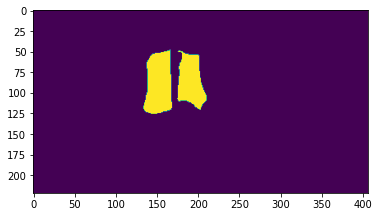

(222, 407)


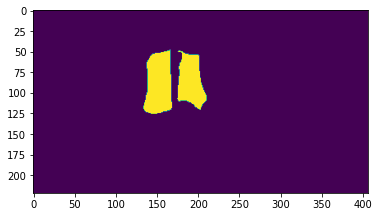

(222, 407)


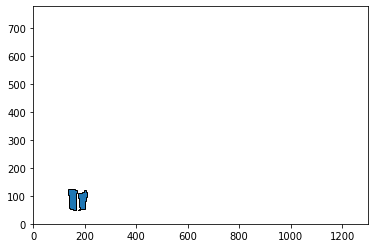

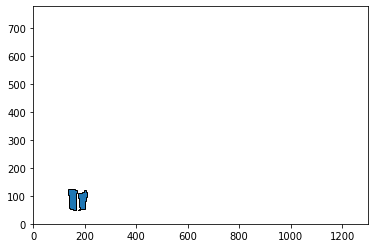

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577172000, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A92CE370>, '_exterior': <weakref at 0x00000209831AF450; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577171760, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A92CE370>, '_exterior': <weakref at 0x00000209A9E82270; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  2
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577186080, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A92CBD00>, '_exterior': <weakref at 0x00000209A7B42D10; dead>}
This is the 

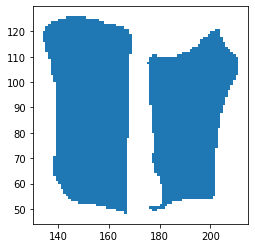

I am still a Polygon
I am still a Polygon
This is after close_holes:


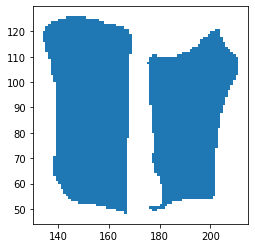

This is the Area:  1680.0
This is the Area:  2148.0
This is the Buffer  -1
This is the Area:  2139.661419212324
This is the Area:  1660.809943767085
Only larger than this survives: 301
I am still a Polygon
I am still a Polygon
This is the Area:  2139.661419212324
This is the Area:  1660.809943767085
                                            geometry   method         area
1  POLYGON ((134.999 115.999, 134.951 116.001, 13...  grabcut  2139.661419
0  POLYGON ((175.992 107.014, 175.961 107.072, 17...  grabcut  1660.809944


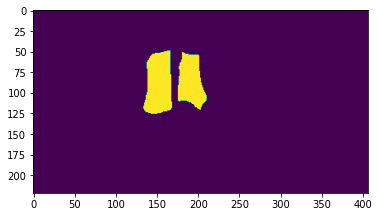

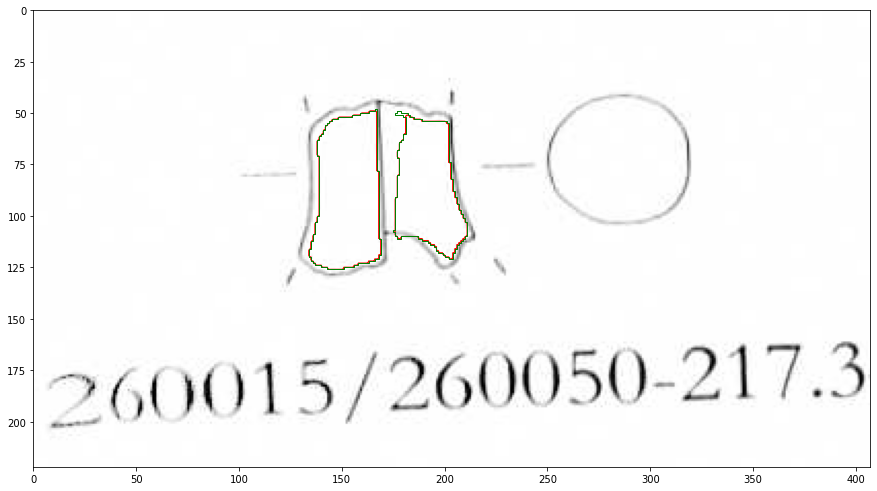

This is the segmented image: (222, 407) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/althiburos_ed/0b16bcc4-be17-4fb6-aaae-32cd6e9863a5
<class 'numpy.ndarray'>
CountNonZero: 15233
any smalle than 255
firstkernel (115, 57)
This is the Kernel to erode the detectedmask:  (9, 9)


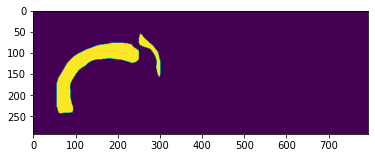

(292, 794)


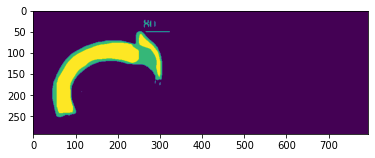

(292, 794)


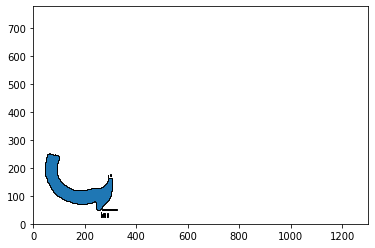

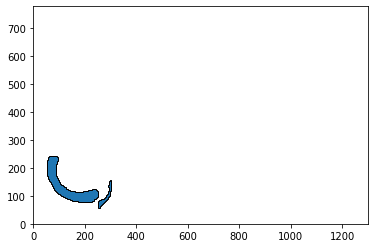

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240586718496, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096EAA2DF0>, '_exterior': <weakref at 0x0000020972965400; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240586722256, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096EAA2DF0>, '_exterior': <weakref at 0x000002097293F900; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240586721296, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096EAA2DF0>, '_exterior': <weakref at 0x000002097293FB80; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240586722336, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

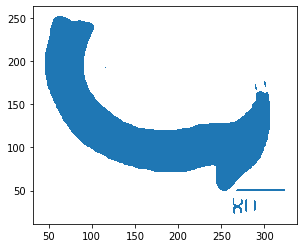

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


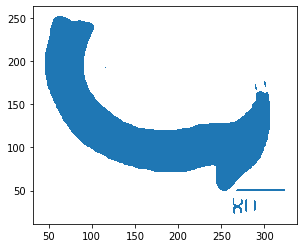

This is the Area:  113.0
This is the Area:  17547.0
This is the Area:  11.0
This is the Area:  9.0
This is the Area:  23.0
This is the Area:  37.0
This is the Area:  90.0
This is the Area:  1.0
This is the Buffer  -2
This is the Area:  17424.1497678394
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 772
I am still a Polygon
This is the Area:  17424.1497678394
                                            geometry   method          area
1  POLYGON ((46.972 184.014, 46.816 184.118, 46.6...  grabcut  17424.149768


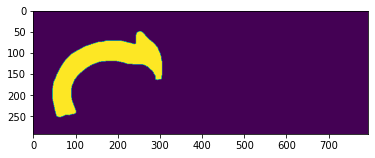

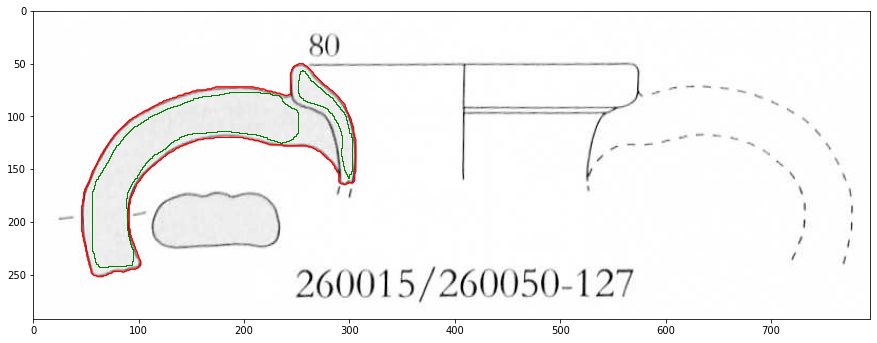

This is the segmented image: (292, 794) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/althiburos_ed/9db12411-0d45-4c5f-a722-1abac13212e8
<class 'numpy.ndarray'>
CountNonZero: 1390
any smalle than 255
firstkernel (24, 12)
This is the Kernel to erode the detectedmask:  (4, 4)


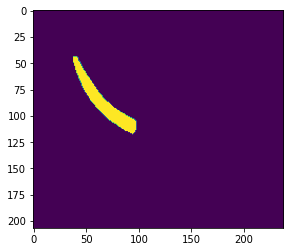

(207, 238)


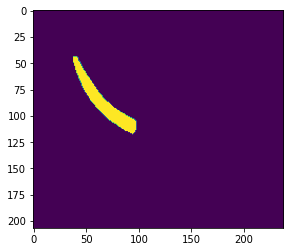

(207, 238)


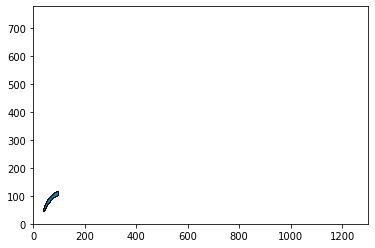

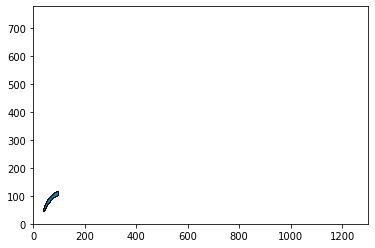

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240470392736, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A7D18D00>, '_exterior': <weakref at 0x000002096B35F900; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240457579728, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA046DC0>, '_exterior': <weakref at 0x000002096B51A900; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
[{'geometry': <shapely.geometry.polygon.Polygon object at 0x00000209AA046760>, 'method': 'detected'}]
This is before close_holes:


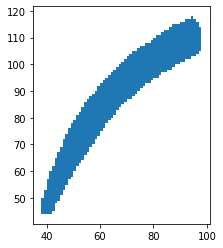

I am still a Polygon
This is after close_holes:


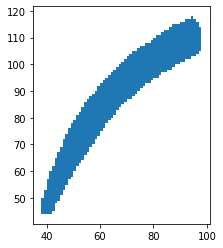

This is the Area:  973.0
This is the Buffer  -1
This is the Area:  950.7276637931798
Only larger than this survives: 164
I am still a Polygon
This is the Area:  950.7276637931798
                                            geometry   method        area
0  POLYGON ((38.999 50.001, 39.000 50.025, 39.000...  grabcut  950.727664


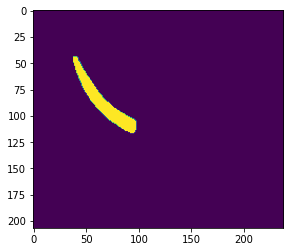

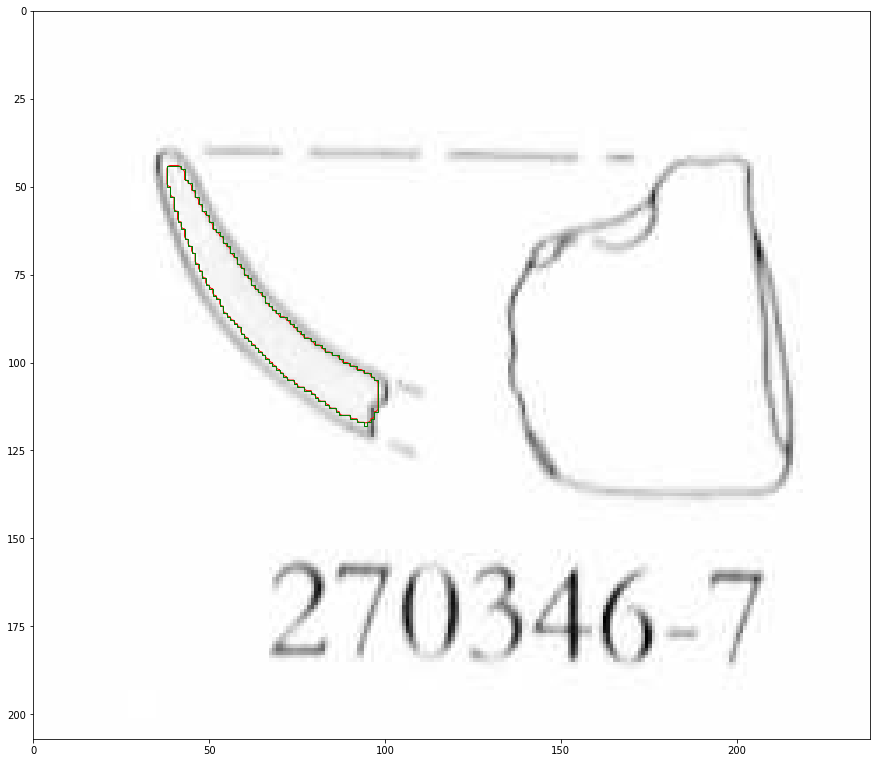

This is the segmented image: (207, 238) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/bonifay2004_ed/47bfa149-d298-4c1b-a204-c3b06939995f
<class 'numpy.ndarray'>
CountNonZero: 9007
any smalle than 255
firstkernel (194, 97)
This is the Kernel to erode the detectedmask:  (12, 12)


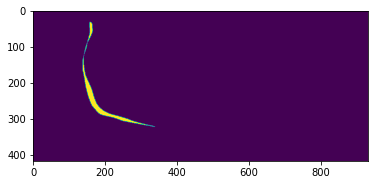

(417, 931)


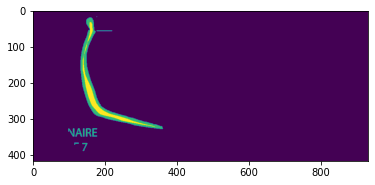

(417, 931)


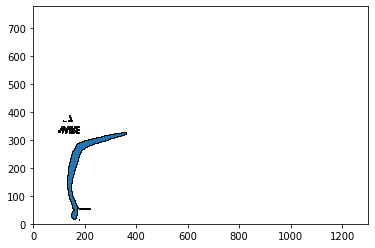

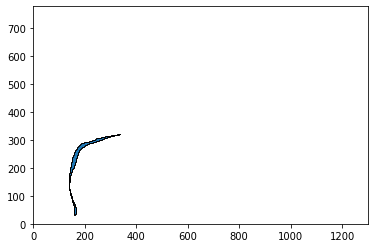

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240506485152, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A8EC6190>, '_exterior': <weakref at 0x00000209A77304F0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240506485792, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A8EC6190>, '_exterior': <weakref at 0x00000209A4B0EA40; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240458745232, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A8EC6190>, '_exterior': <weakref at 0x00000209A7730EF0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240458744672, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

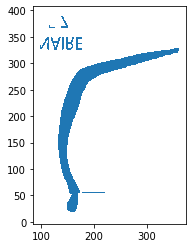

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  50.0
This is the smallerthanarea:  388
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  27.0
This is the smallerthanarea:  388
I am still a Polygon
I am still a Polygon
This is after close_holes:


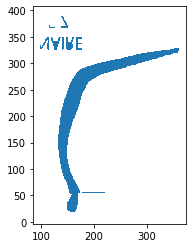

This is the Area:  8963.0
This is the Area:  86.0
This is the Area:  169.0
This is the Area:  2.0
This is the Area:  248.0
This is the Area:  103.0
This is the Area:  90.0
This is the Area:  196.0
This is the Area:  42.0
This is the Area:  163.0
This is the Buffer  -3
This is the Area:  8785.973204174743
This is the Area:  170.79646283942373
This is the Area:  117.25559659158311
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 1294
I am still a Polygon
This is the Area:  8785.973204174743
                                            geometry   method         area
0  POLYGON ((132.985 136.008, 132.765 136.230, 13...  grabcut  8785.973204


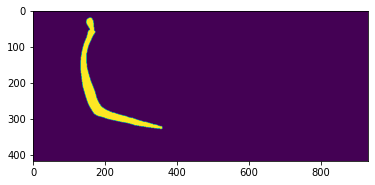

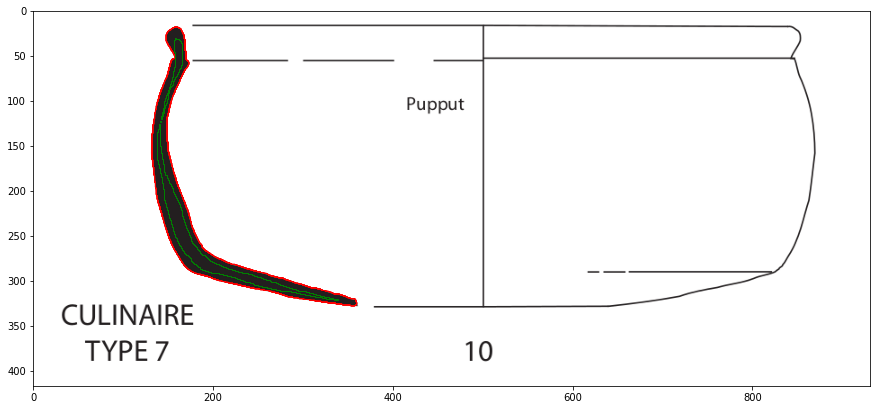

This is the segmented image: (417, 931) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/bonifay2004_ed/ba0dffaf-5f65-44e0-aee3-c63f50e2e877
<class 'numpy.ndarray'>
CountNonZero: 7329
any smalle than 255
firstkernel (385, 192)
This is the Kernel to erode the detectedmask:  (17, 17)


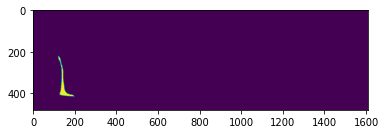

(479, 1609)


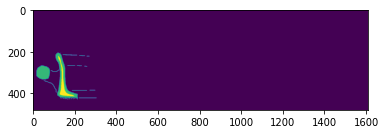

(479, 1609)


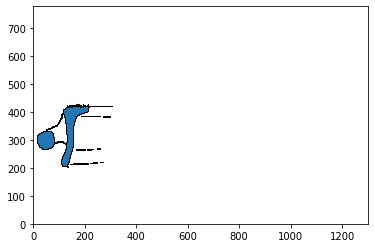

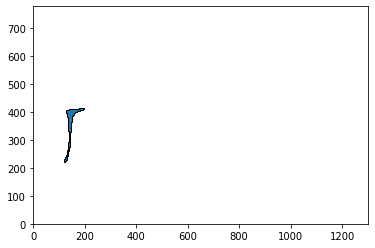

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497587392, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9DEDC10>, '_exterior': <weakref at 0x00000209A7CC9540; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497587552, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9DEDC10>, '_exterior': <weakref at 0x00000209A9E753B0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497587632, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9DEDC10>, '_exterior': <weakref at 0x00000209A9E75040; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497584992, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

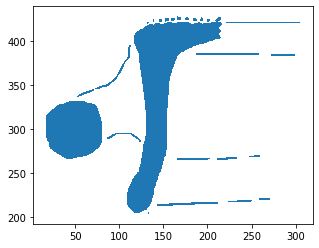

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


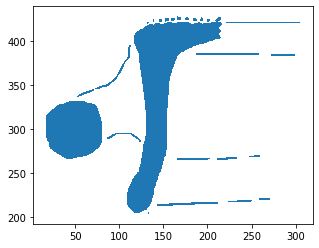

This is the Area:  168.0
This is the Area:  54.0
This is the Area:  26.0
This is the Area:  27.0
This is the Area:  144.0
This is the Area:  57.0
This is the Area:  48.0
This is the Area:  7833.0
This is the Area:  19.0
This is the Area:  148.0
This is the Area:  72.0
This is the Area:  10.0
This is the Area:  9.0
This is the Area:  11.0
This is the Area:  10.0
This is the Area:  13.0
This is the Area:  11.0
This is the Area:  15.0
This is the Area:  9.0
This is the Area:  6.0
This is the Area:  8.0
This is the Area:  2.0
This is the Area:  89.0
This is the Area:  45.0
This is the Area:  143.0
This is the Area:  3489.0
This is the Buffer  -4
This is the Area:  7703.758707533872
This is the Area:  3443.5059844580055
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 2569
I am still a Polygon
I am still a Polygon
This is the Area:  7703.758707533872
This is the Area:  3443.5059844580055
                                             geometr

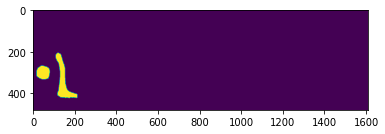

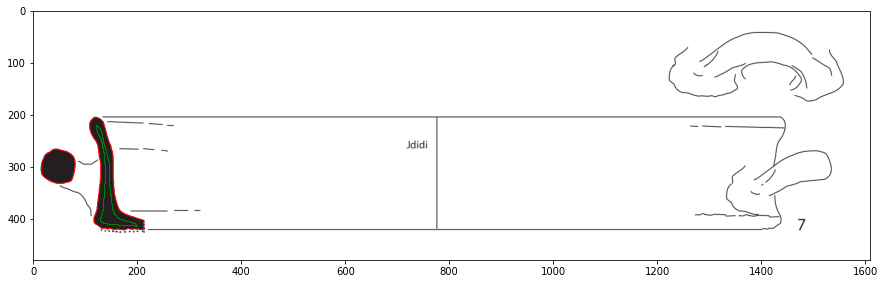

This is the segmented image: (479, 1609) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/bonifay2004_ed/d7c6cf36-95d6-4191-af8e-1d9bd36b49cb
<class 'numpy.ndarray'>
CountNonZero: 4593
any smalle than 255
firstkernel (252, 126)
This is the Kernel to erode the detectedmask:  (14, 14)


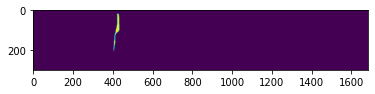

(300, 1683)


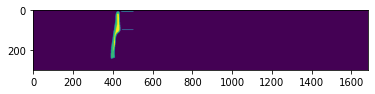

(300, 1683)


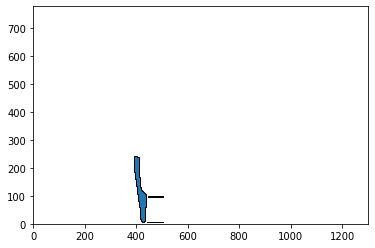

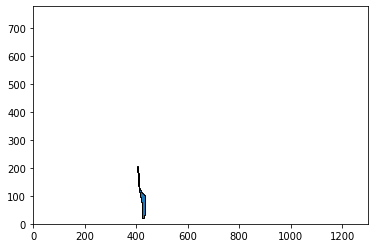

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2225853724880, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA673EE0>, '_exterior': <weakref at 0x00000209A9A00680; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2225853724320, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA673EE0>, '_exterior': <weakref at 0x00000209A9A08860; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2225853725600, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA673EE0>, '_exterior': <weakref at 0x00000209AA667860; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  3
Here comes detected multi2single:
I am Multipolygon
This is the 

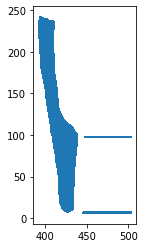

I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


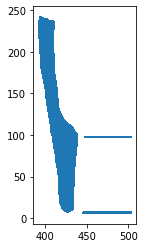

This is the Area:  179.0
This is the Area:  114.0
This is the Area:  4787.0
This is the Buffer  -3
This is the Area:  4729.851698319825
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 1683
I am still a Polygon
This is the Area:  4729.851698319825
                                            geometry   method         area
2  POLYGON ((391.985 216.008, 391.765 216.230, 39...  grabcut  4729.851698


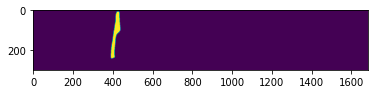

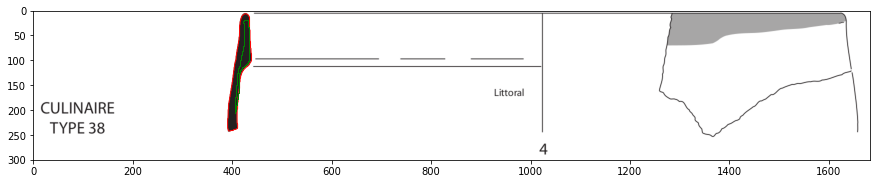

This is the segmented image: (300, 1683) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/hayes1972_edv2/f93b5a40-78a4-42b1-8b8a-0a0cf572cda7
<class 'numpy.ndarray'>
CountNonZero: 19126
any smalle than 255
firstkernel (155, 77)
This is the Kernel to erode the detectedmask:  (11, 11)


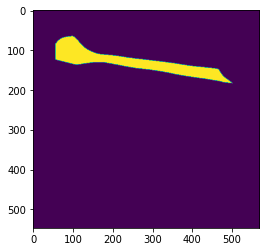

(547, 569)


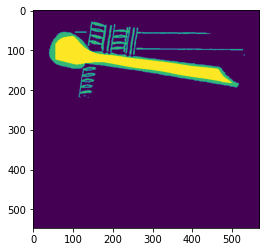

(547, 569)


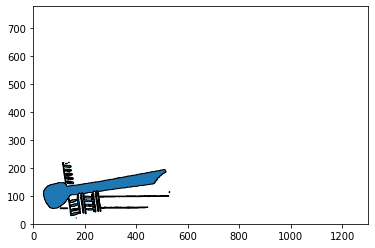

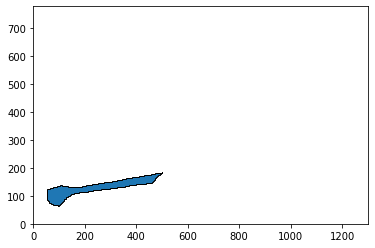

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240575160752, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A746E610>, '_exterior': <weakref at 0x00000209A9785A90; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240575160992, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A746E610>, '_exterior': <weakref at 0x00000209A9A994A0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240575164512, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A746E610>, '_exterior': <weakref at 0x00000209A9AA0D60; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240575164912, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

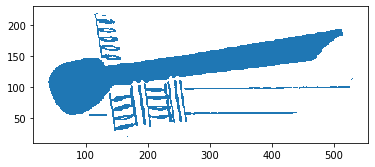

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  24.0
This is the smallerthanarea:  311
This is the interior areasize:  26.0
This is the smallerthanarea:  311
This is the interior areasize:  251.0
This is the smallerthanarea:  311
This is the interior areasize:  297.0
This is the smallerthanarea:  311
This is the interior areasize:  213.0
This is the smallerthanarea:  311
This is the interior areasize:  10.0
This is the smallerthanarea:  311
I am still a Polygon
I am still a Polygon
This is the interior areasize:  266.0
This is the smallerthanarea:  311
This is the interior areasize:  315.0
This is the smallerthanarea:  311
This interior will make a difference
This is the interior areasize:  280.0
This is the smallerthanarea:  311
This is the interior areasize:  5.0
This is the smallerthanarea:  311
This is the interior areasize:  7.0
This is the smallerthan

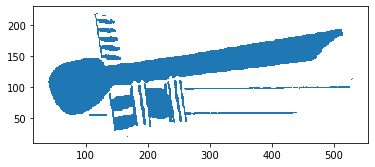

This is the Area:  6.0
This is the Area:  689.0
This is the Area:  20378.0
This is the Area:  3.0
This is the Area:  766.0
This is the Area:  296.0
This is the Area:  2157.0
This is the Area:  285.0
This is the Area:  1842.0
This is the Area:  1.0
This is the Area:  1174.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  86.0
This is the Area:  7.0
This is the Buffer  -2
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240469559120, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4697C70>, '_exterior': <weakref at 0x00000209A9A99400; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240469557280, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4697C70>, '_exterior': <weakref at 0x00000209A741FEF0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': Fa

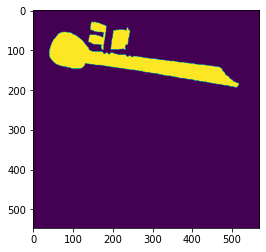

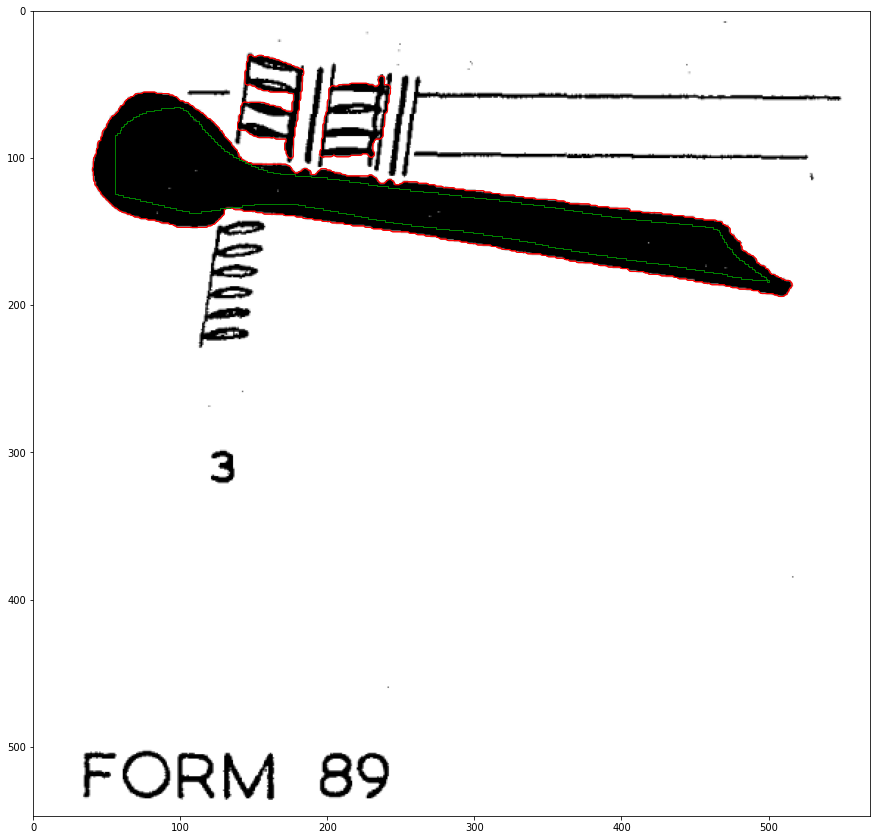

This is the segmented image: (547, 569) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/hayes1972_edv2/76c953ce-6208-4d85-8658-f93b6b3103ff
<class 'numpy.ndarray'>
CountNonZero: 46357
any smalle than 255
firstkernel (242, 121)
This is the Kernel to erode the detectedmask:  (13, 13)


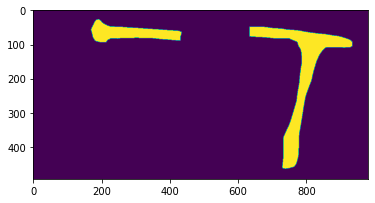

(494, 981)


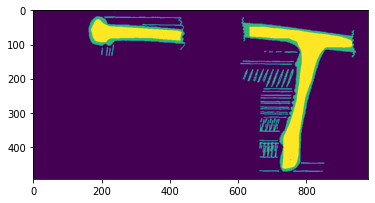

(494, 981)


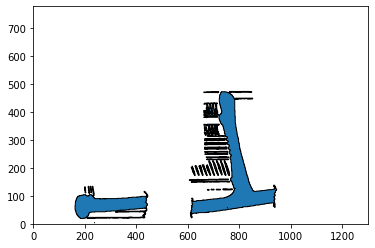

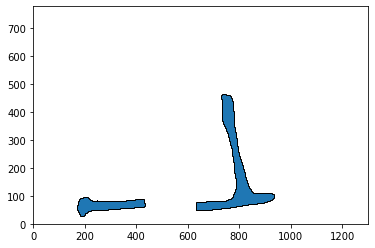

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(754.0, 58.0), (754.0, 57.0), (755.0, 57.0), (755.0, 58.0), (754.0, 58.0), (784.0, 126.0), (785.0, 126.0), (785.0, 127.0), (784.0, 127.0), (784.0, 126.0)]
{'_other_owned': True, '_is_empty': False, '__geom__': 2240456724208, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020974D5CBE0>, '_exterior': <weakref at 0x00000209A7C57180; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240456725568, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020974D5CBE0>, '_exterior': <weakref at 0x00000209A774A770; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240456723888, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020974D5CBE0>, '_exterior': <weakref at 0x00000209A774A9A0; dead>}
This is the interiors of mul

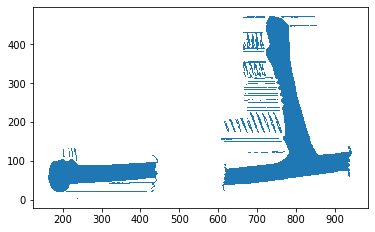

I am still a Polygon
This is the interior areasize:  1.0
This is the smallerthanarea:  484
This is the interior areasize:  1.0
This is the smallerthanarea:  484
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  3.0
This is the smallerthanarea:  484
This is the interior areasize:  10.0
This is the smallerthanarea:  484
This is the interior areasize:  1.0
This is the smallerthanarea:  484
This is the interior areasize:  2.0
This is the smallerthanarea:  484
This is the interior areasize:  4.0
This is the smallerthanarea:  484
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  2.0
This is the smallerthanarea:  484
This is the interior areasize:  2.0
This is the smallerthanar

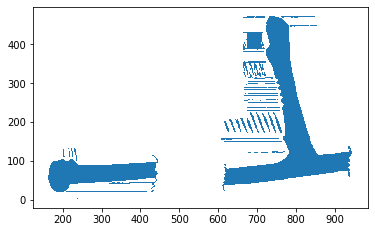

This is the Area:  34841.0
This is the Area:  180.0
This is the Area:  257.0
This is the Area:  120.0
This is the Area:  368.0
This is the Area:  288.0
This is the Area:  203.0
This is the Area:  1.0
This is the Area:  217.0
This is the Area:  350.0
This is the Area:  257.0
This is the Area:  231.0
This is the Area:  1.0
This is the Area:  232.0
This is the Area:  222.0
This is the Area:  185.0
This is the Area:  201.0
This is the Area:  244.0
This is the Area:  169.0
This is the Area:  168.0
This is the Area:  136.0
This is the Area:  241.0
This is the Area:  37.0
This is the Area:  40.0
This is the Area:  771.0
This is the Area:  158.0
This is the Area:  1864.0
This is the Area:  244.0
This is the Area:  116.0
This is the Area:  44.0
This is the Area:  13.0
This is the Area:  232.0
This is the Area:  28.0
This is the Area:  45.0
This is the Area:  185.0
This is the Area:  43.0
This is the Area:  17.0
This is the Area:  178.0
This is the Area:  36.0
This is the Area:  26.0
This is the

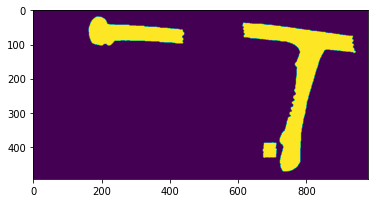

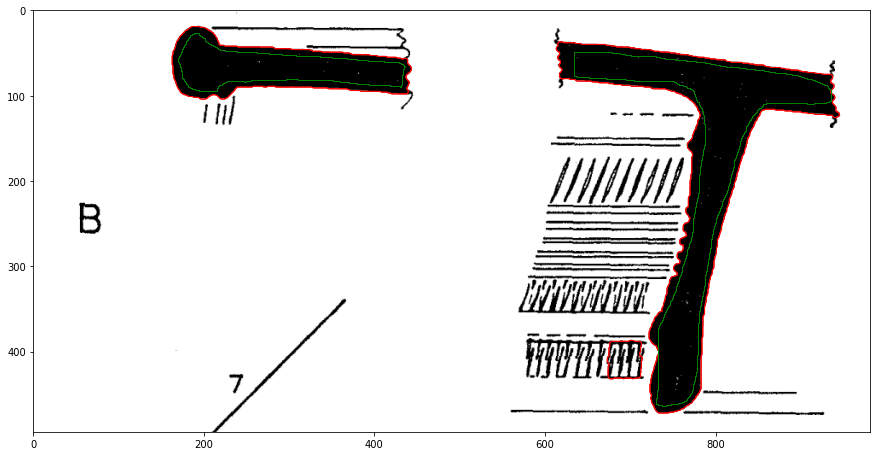

This is the segmented image: (494, 981) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/hayes1972_edv2/7c70ee0d-5054-43ca-8a34-014fa5d53dcb
<class 'numpy.ndarray'>
CountNonZero: 11203
any smalle than 255
firstkernel (104, 52)
This is the Kernel to erode the detectedmask:  (9, 9)


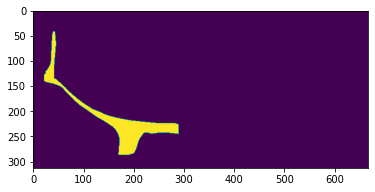

(313, 667)


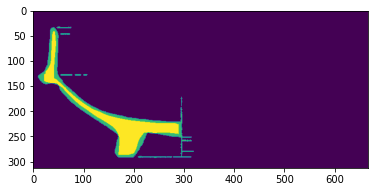

(313, 667)


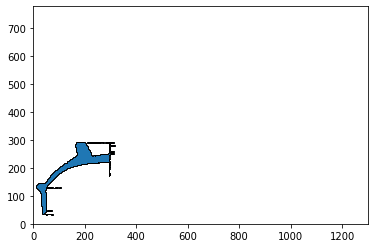

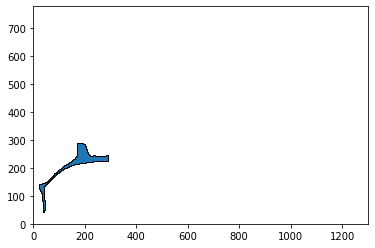

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587742352, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209729681C0>, '_exterior': <weakref at 0x00000209A94AF9A0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587739152, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209729681C0>, '_exterior': <weakref at 0x00000209A7C53B80; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587737472, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209729681C0>, '_exterior': <weakref at 0x00000209A94AF900; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587739072, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

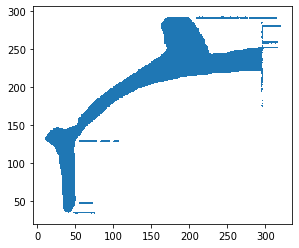

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


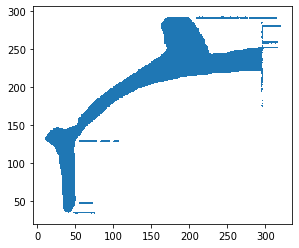

This is the Area:  11881.0
This is the Area:  24.0
This is the Area:  150.0
This is the Area:  21.0
This is the Area:  35.0
This is the Area:  69.0
This is the Area:  64.0
This is the Area:  53.0
This is the Buffer  -2
This is the Area:  11389.437897772259
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 695
I am still a Polygon
This is the Area:  11389.437897772259
                                            geometry   method          area
0  POLYGON ((10.998 129.998, 10.972 130.014, 10.8...  grabcut  11389.437898


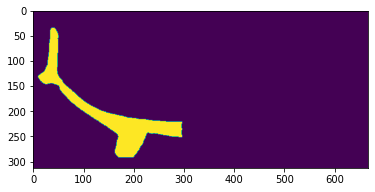

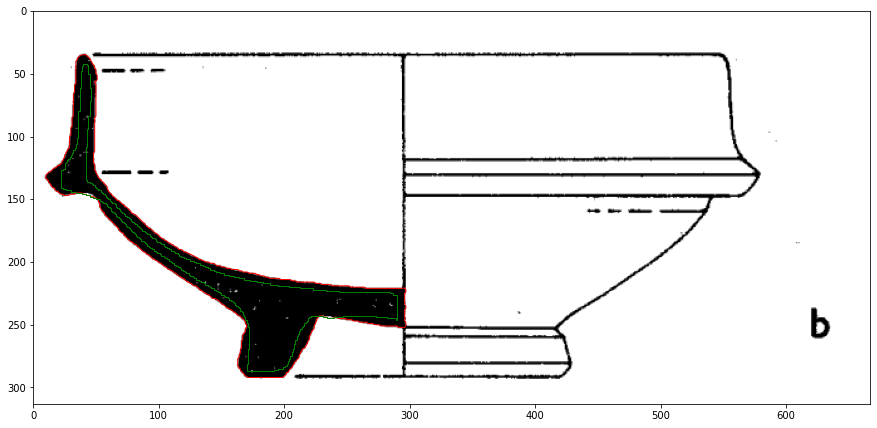

This is the segmented image: (313, 667) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/lattara6_edv2/024766f9-10a1-4719-830f-5afc75069560
<class 'numpy.ndarray'>
CountNonZero: 3929
any smalle than 255
firstkernel (50, 25)
This is the Kernel to erode the detectedmask:  (6, 6)


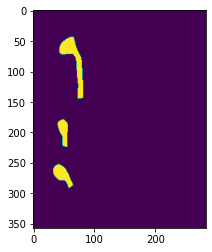

(357, 283)


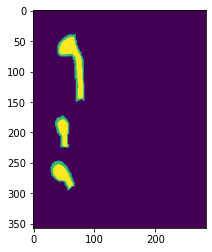

(357, 283)


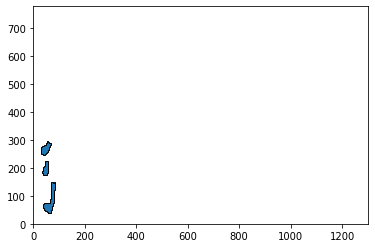

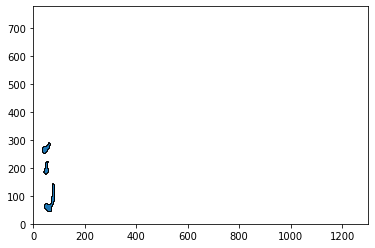

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240220627712, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A72C1C40>, '_exterior': <weakref at 0x0000020634A349F0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240220627792, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A72C1C40>, '_exterior': <weakref at 0x00000209A4A6D630; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240220627952, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A72C1C40>, '_exterior': <weakref at 0x000002098E41B4A0; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  3
Here comes detected multi2single:
I am Multipolygon
This is the 

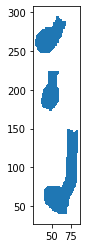

I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


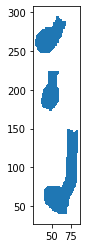

This is the Area:  2131.0
This is the Area:  1068.0
This is the Area:  848.0
This is the Buffer  -1
This is the Area:  2119.779424011111
This is the Area:  1056.1339806475441
This is the Area:  840.8789445124834
Only larger than this survives: 336
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the Area:  2119.779424011111
This is the Area:  1056.1339806475441
This is the Area:  840.8789445124834
                                            geometry   method         area
0  POLYGON ((40.999 56.999, 40.951 57.001, 40.856...  grabcut  2119.779424
1  POLYGON ((29.999 255.999, 29.951 256.001, 29.8...  grabcut  1056.133981
2  POLYGON ((36.999 181.999, 36.951 182.001, 36.8...  grabcut   840.878945


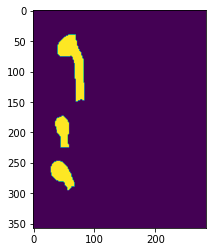

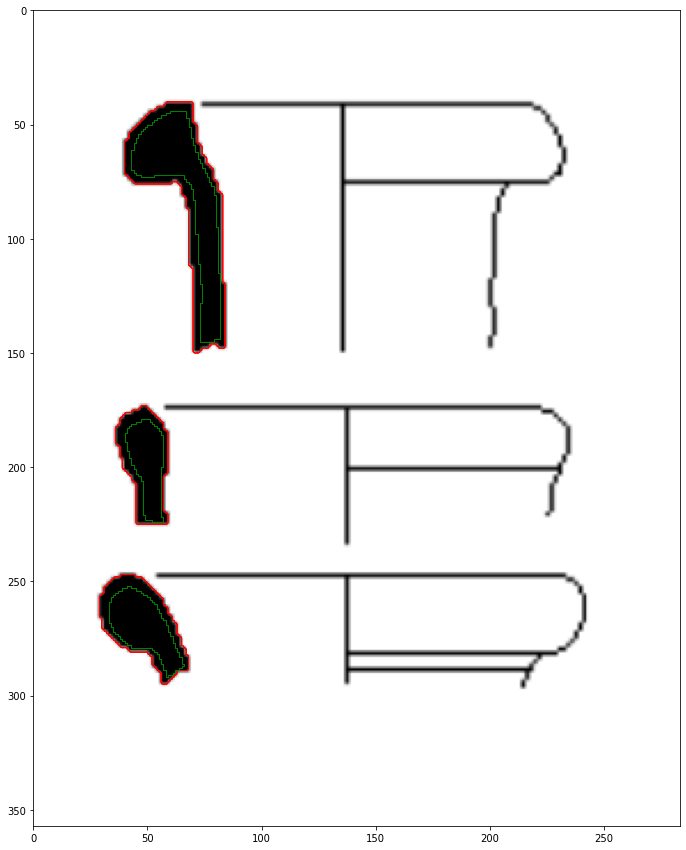

This is the segmented image: (357, 283) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/lattara6_edv2/942fb9fd-bba9-408f-b4e9-711a4b3c0453
<class 'numpy.ndarray'>
CountNonZero: 3677
any smalle than 255
firstkernel (51, 25)
This is the Kernel to erode the detectedmask:  (6, 6)


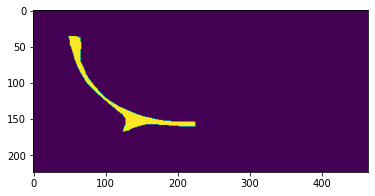

(224, 464)


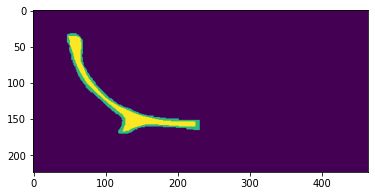

(224, 464)


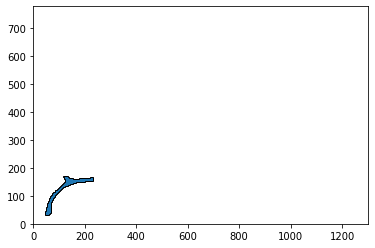

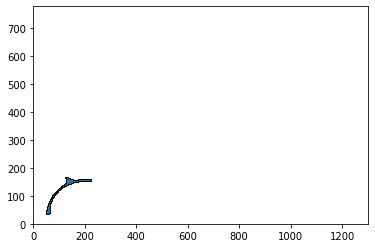

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240457580848, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002099CF5B0A0>, '_exterior': <weakref at 0x00000209AA038770; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240457562688, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9F1F190>, '_exterior': <weakref at 0x00000209A91A3E00; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
[{'geometry': <shapely.geometry.polygon.Polygon object at 0x00000209A9222F70>, 'method': 'detected'}]
This is before close_holes:


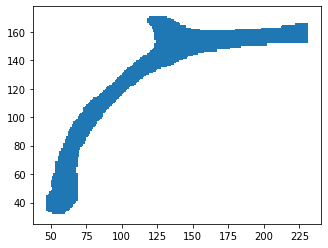

I am still a Polygon
This is after close_holes:


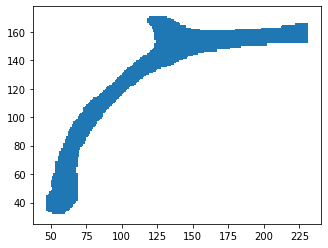

This is the Area:  3788.0
This is the Buffer  -1
This is the Area:  3750.668143645217
Only larger than this survives: 346
I am still a Polygon
This is the Area:  3750.668143645217
                                            geometry   method         area
0  POLYGON ((47.999 33.999, 47.951 34.001, 47.856...  grabcut  3750.668144


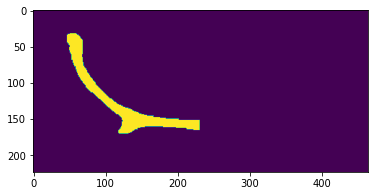

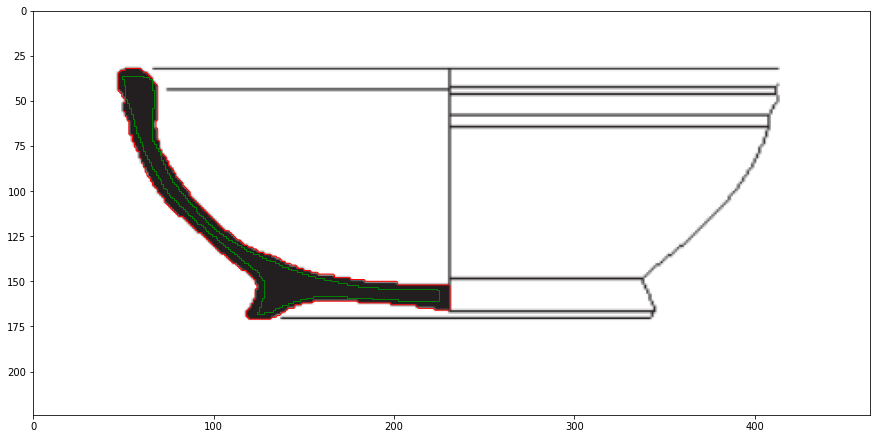

This is the segmented image: (224, 464) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/lattara6_edv2/c429dad4-463b-4ff9-a186-d5f8d20ef0ea
<class 'numpy.ndarray'>
CountNonZero: 6289
any smalle than 255
firstkernel (84, 42)
This is the Kernel to erode the detectedmask:  (8, 8)


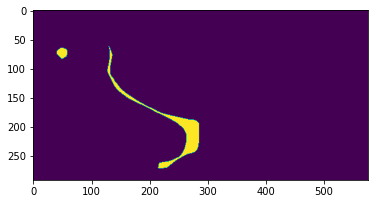

(292, 577)


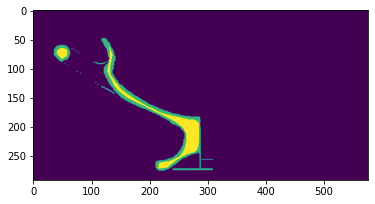

(292, 577)


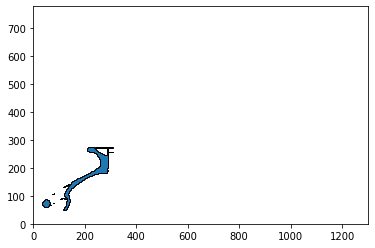

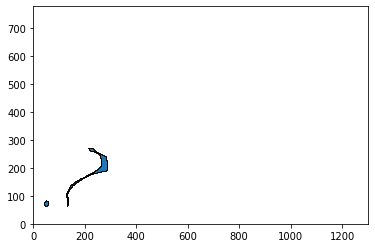

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587749632, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9CBEFD0>, '_exterior': <weakref at 0x00000209AA9E5400; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587751472, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9CBEFD0>, '_exterior': <weakref at 0x00000209A94BD950; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587751552, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9CBEFD0>, '_exterior': <weakref at 0x00000209A9342540; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587752112, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

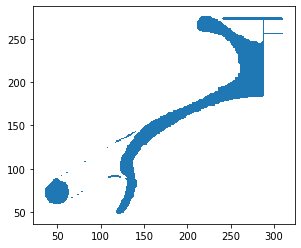

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


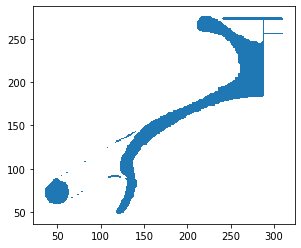

This is the Area:  4.0
This is the Area:  32.0
This is the Area:  4.0
This is the Area:  6108.0
This is the Area:  1.0
This is the Area:  12.0
This is the Area:  34.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  2.0
This is the Area:  622.0
This is the Area:  2.0
This is the Area:  2.0
This is the Buffer  -2
This is the Area:  5706.925180731786
This is the Area:  605.2197429417972
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 561
I am still a Polygon
I am still a Polygon
This is the Area:  5706.925180731786
This is the Area:  605.2197429417972
                                             geometry   method         area
3   POLYGON ((118.998 53.001, 119.000 53.049, 119....  grabcut  5706.925181
16  POLYGON ((36.998 66.998, 36.972 67.014, 36.801...  grabcut   605.219743


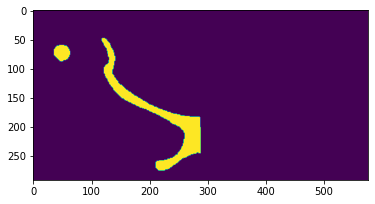

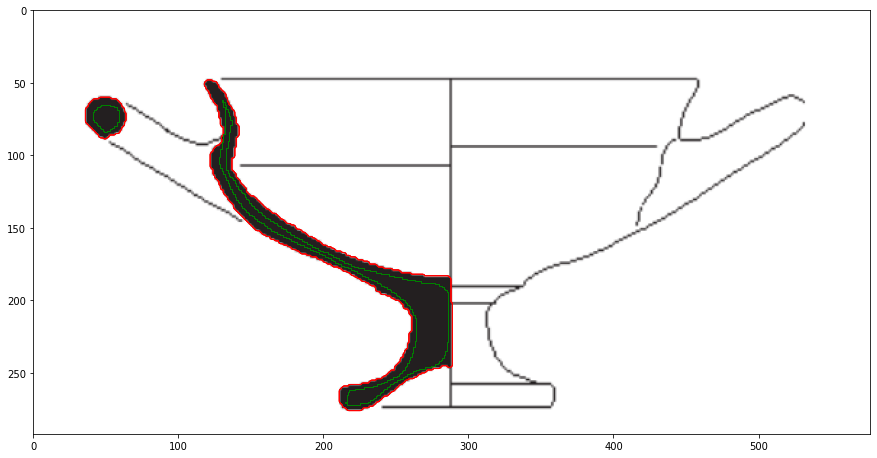

This is the segmented image: (292, 577) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sabratha_ed/d088d0b8-a30c-4ef1-a5c7-15ae7450affa
<class 'numpy.ndarray'>
CountNonZero: 1738
any smalle than 255
firstkernel (75, 37)
This is the Kernel to erode the detectedmask:  (7, 7)


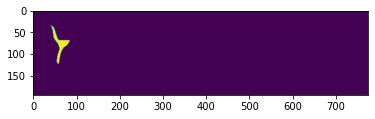

(195, 775)


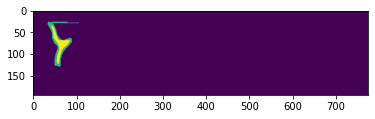

(195, 775)


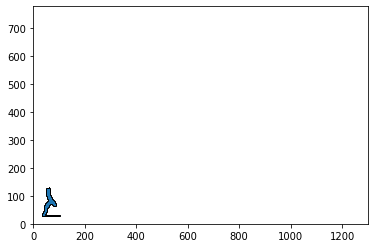

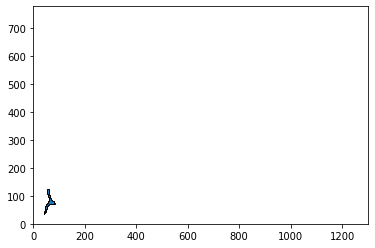

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240584373008, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4BA95B0>, '_exterior': <weakref at 0x00000209A4A764A0; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240584350688, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9ED8D30>, '_exterior': <weakref at 0x00000209A46E1B30; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240584347728, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A9ED8D30>, '_exterior': <weakref at 0x00000209A4736C70; dead>}
What kind of

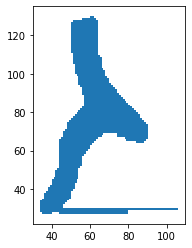

I am still a Polygon
This is after close_holes:


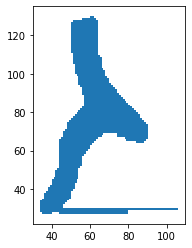

This is the Area:  1996.0
This is the Buffer  -1
This is the Area:  1949.285645283961
Only larger than this survives: 503
I am still a Polygon
This is the Area:  1949.285645283961
                                            geometry   method         area
0  POLYGON ((34.999 27.999, 34.951 28.001, 34.850...  grabcut  1949.285645


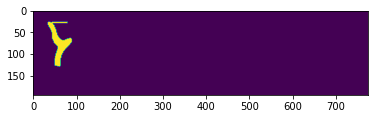

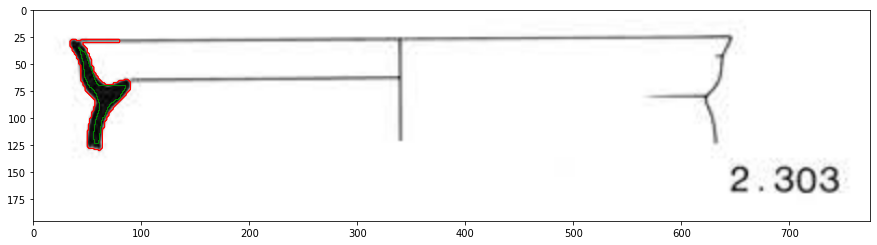

This is the segmented image: (195, 775) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sabratha_ed/028fba73-cd27-4b11-b2b5-b61a7fec4600
<class 'numpy.ndarray'>
CountNonZero: 8922
any smalle than 255
firstkernel (118, 59)
This is the Kernel to erode the detectedmask:  (9, 9)


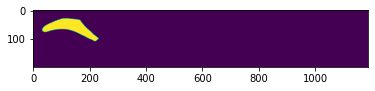

(200, 1187)


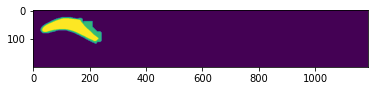

(200, 1187)


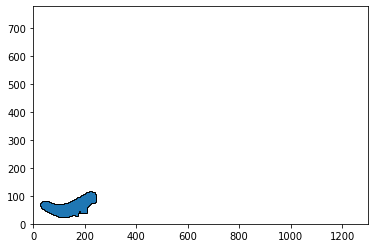

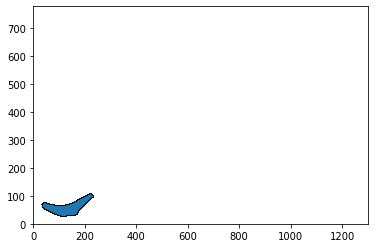

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577192240, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A96FB550>, '_exterior': <weakref at 0x00000209A77A2A90; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577156080, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA9BC310>, '_exterior': <weakref at 0x00000209A73D5220; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
[{'geometry': <shapely.geometry.polygon.Polygon object at 0x00000209AA9BC1F0>, 'method': 'detected'}]
This is before close_holes:


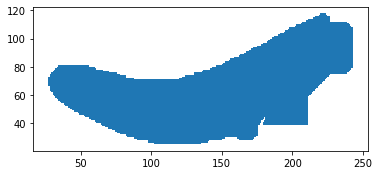

I am still a Polygon
This is after close_holes:


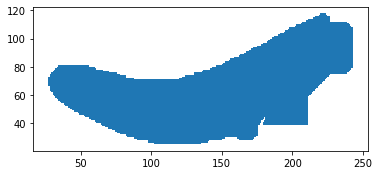

This is the Area:  10243.0
This is the Buffer  -2
This is the Area:  10171.149390429922
Only larger than this survives: 791
I am still a Polygon
This is the Area:  10171.149390429922
                                            geometry   method         area
0  POLYGON ((27.000 71.270, 27.009 71.458, 27.035...  grabcut  10171.14939


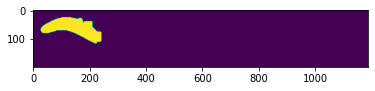

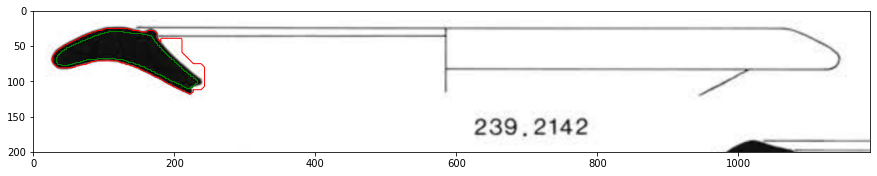

This is the segmented image: (200, 1187) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sabratha_ed/cafb5ed8-40d4-4048-80b9-13d055b94e8b
<class 'numpy.ndarray'>
CountNonZero: 2112
any smalle than 255
firstkernel (127, 63)
This is the Kernel to erode the detectedmask:  (10, 10)


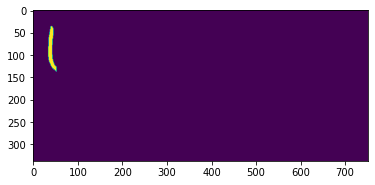

(338, 752)


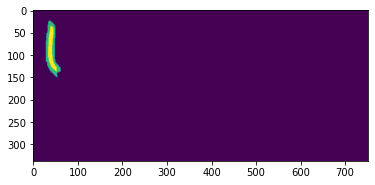

(338, 752)


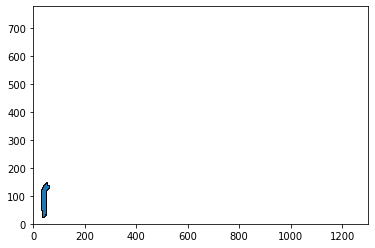

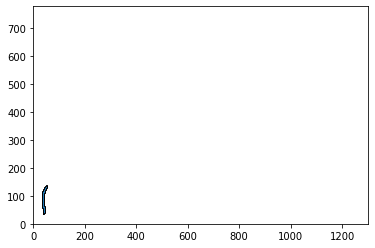

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2239674155568, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A8F0BE20>, '_exterior': <weakref at 0x00000209A8DAE040; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2239674158208, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A8F0BE20>, '_exterior': <weakref at 0x0000020974D3AB30; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  2
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2239674269728, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A733C9D0>, '_exterior': <weakref at 0x00000209A7358EF0; dead>}
What kind of

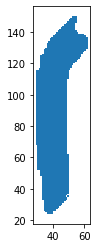

I am still a Polygon
I am still a Polygon
This is after close_holes:


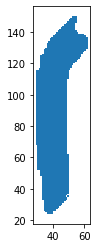

This is the Area:  2317.0
This is the Area:  1.0
This is the Buffer  -2
This is the Area:  2281.083214907053
This is the Area:  0.0
Only larger than this survives: 847
I am still a Polygon
This is the Area:  2281.083214907053
                                            geometry   method         area
0  POLYGON ((29.972 68.014, 29.816 68.118, 29.670...  grabcut  2281.083215


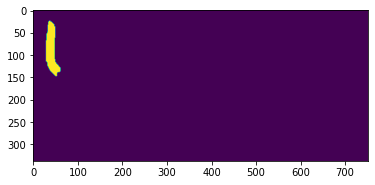

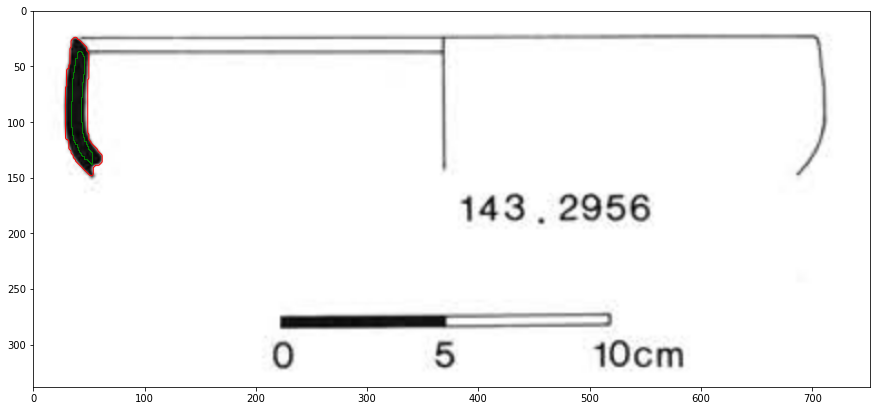

This is the segmented image: (338, 752) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sidikhrebish_ed/cc02ee50-c9fc-4b06-b605-73f34a75e3fa
<class 'numpy.ndarray'>
CountNonZero: 5935
any smalle than 255
firstkernel (53, 26)
This is the Kernel to erode the detectedmask:  (6, 6)


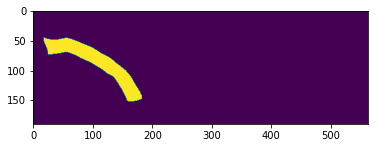

(190, 563)


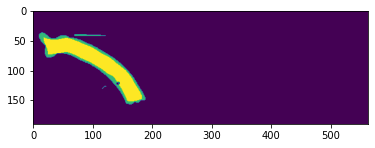

(190, 563)


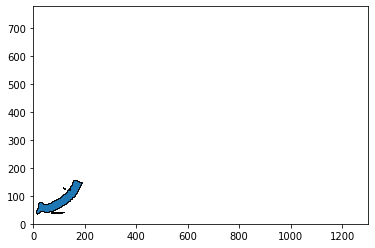

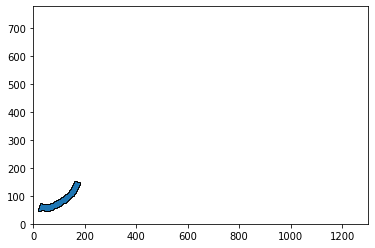

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(144.0, 124.0), (141.0, 124.0), (141.0, 123.0), (140.0, 123.0), (140.0, 121.0), (141.0, 121.0), (141.0, 120.0), (142.0, 120.0), (142.0, 121.0), (143.0, 121.0), (143.0, 122.0), (144.0, 122.0), (144.0, 123.0), (144.0, 124.0)]
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577154000, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4AB8C10>, '_exterior': <weakref at 0x00000209A78BBB30; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577155680, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4AB8C10>, '_exterior': <weakref at 0x00000209A78BB4F0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240577151280, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4AB8C10>, '_exterior'

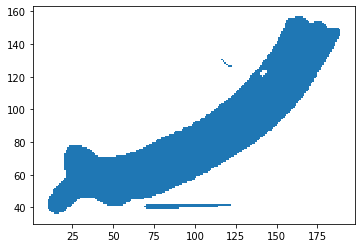

I am still a Polygon
This is the interior areasize:  11.0
This is the smallerthanarea:  106
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


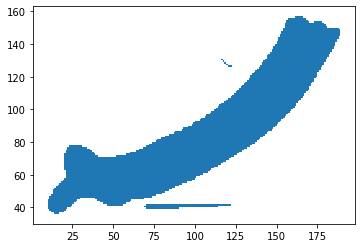

This is the Area:  6167.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  3.0
This is the Area:  117.0
This is the Buffer  -1
This is the Area:  6120.602822918173
This is the Area:  61.01173985268297
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 356
I am still a Polygon
This is the Area:  6120.602822918173
                                            geometry   method         area
0  POLYGON ((10.999 38.999, 10.951 39.001, 10.856...  grabcut  6120.602823


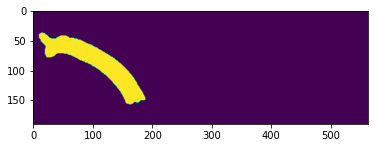

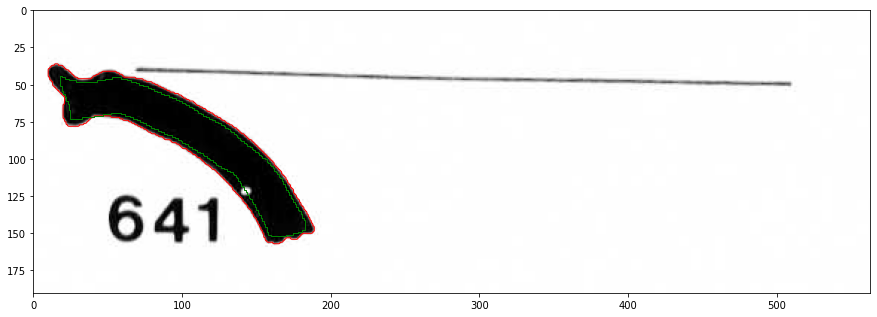

This is the segmented image: (190, 563) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sidikhrebish_ed/ed6a2d04-1e3d-4546-8f45-ec55c42d2276
<class 'numpy.ndarray'>
CountNonZero: 10535
any smalle than 255
firstkernel (59, 29)
This is the Kernel to erode the detectedmask:  (6, 6)


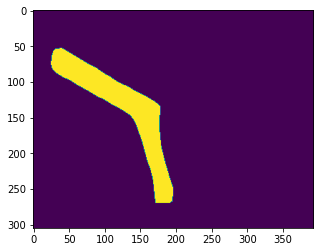

(305, 393)


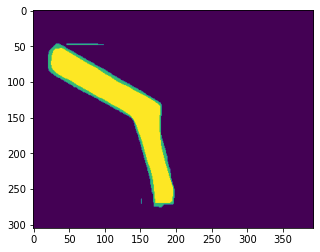

(305, 393)


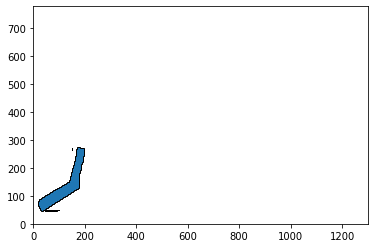

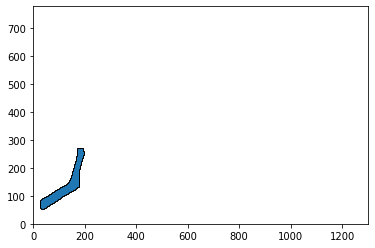

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240469531680, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209713DB040>, '_exterior': <weakref at 0x00000209A9438B80; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240469531040, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209713DB040>, '_exterior': <weakref at 0x00000209731A0680; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240469533520, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209713DB040>, '_exterior': <weakref at 0x00000209A9438180; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  3
Here comes detected multi2single:
I am Multipolygon
This is the 

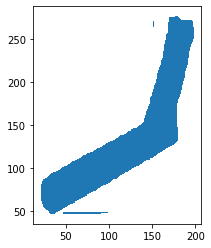

I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


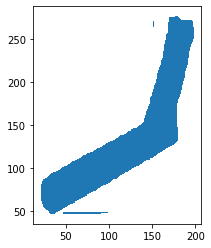

This is the Area:  10685.0
This is the Area:  7.0
This is the Area:  96.0
This is the Buffer  -1
This is the Area:  10636.441700004003
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 399
I am still a Polygon
This is the Area:  10636.441700004003
                                            geometry   method        area
0  POLYGON ((21.999 61.999, 21.951 62.001, 21.856...  grabcut  10636.4417


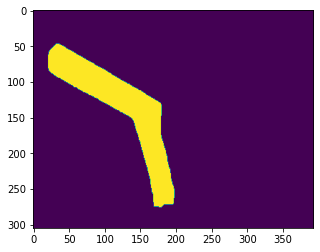

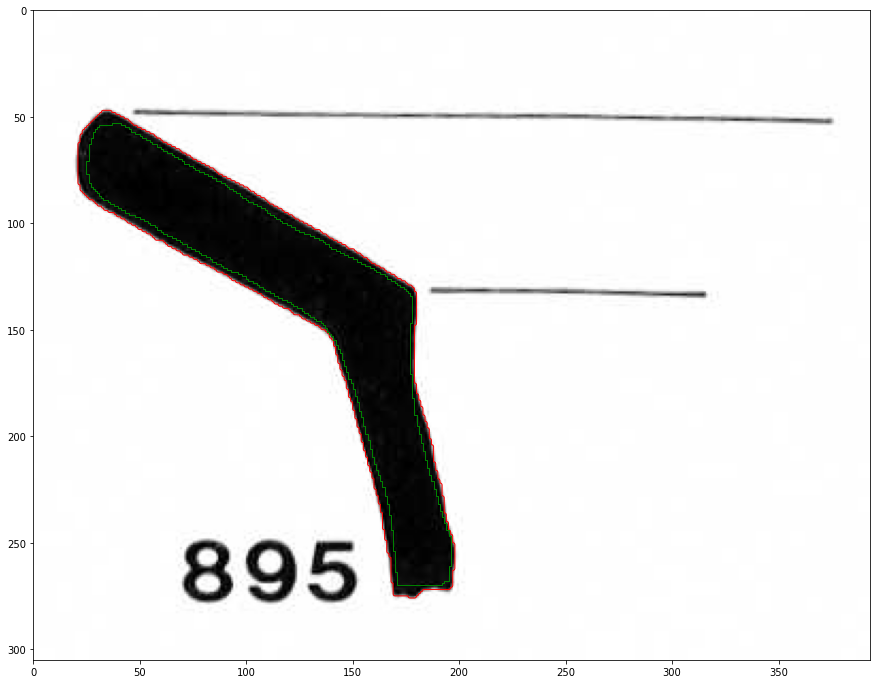

This is the segmented image: (305, 393) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/sidikhrebish_ed/982fa7ae-a89f-4cbf-972b-87f950800bb5
<class 'numpy.ndarray'>
CountNonZero: 10000
any smalle than 255
firstkernel (52, 26)
This is the Kernel to erode the detectedmask:  (6, 6)


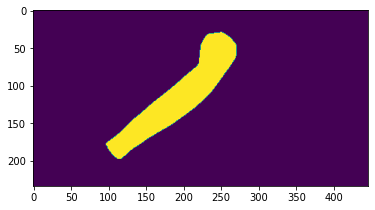

(234, 446)


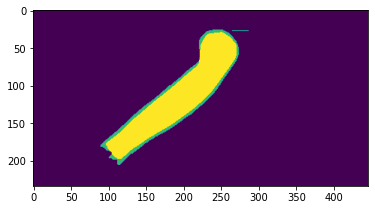

(234, 446)


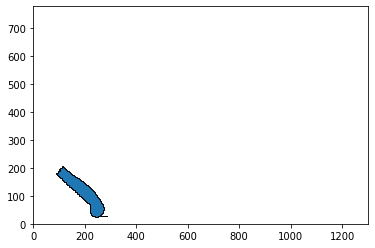

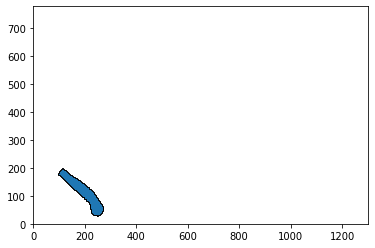

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497735408, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4B8AC10>, '_exterior': <weakref at 0x000002098AA16040; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497733168, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4B8AC10>, '_exterior': <weakref at 0x00000209AA79D9A0; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  2
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497734848, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A4B8AAF0>, '_exterior': <weakref at 0x00000209A49B33B0; dead>}
What kind of

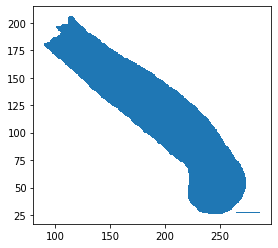

I am still a Polygon
I am still a Polygon
This is after close_holes:


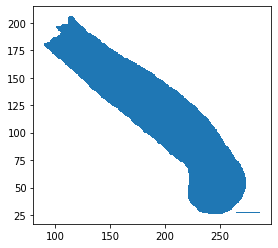

This is the Area:  22.0
This is the Area:  10004.0
This is the Buffer  -1
This is the Area:  9940.992814258814
This is the Area:  0.0
Only larger than this survives: 347
I am still a Polygon
This is the Area:  9940.992814258814
                                            geometry   method         area
1  POLYGON ((90.999 178.999, 90.951 179.001, 90.8...  grabcut  9940.992814


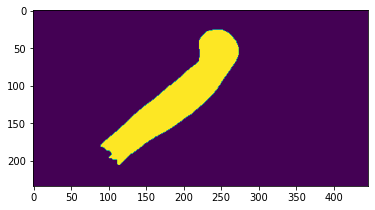

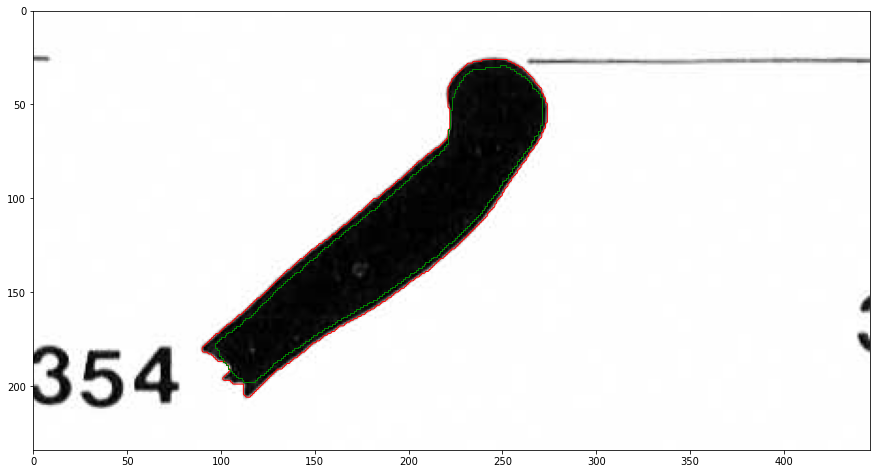

This is the segmented image: (234, 446) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/simitthus_ed/a771bf0c-d889-4f54-b96f-b245068481da
<class 'numpy.ndarray'>
CountNonZero: 11100
any smalle than 255
firstkernel (164, 82)
This is the Kernel to erode the detectedmask:  (11, 11)


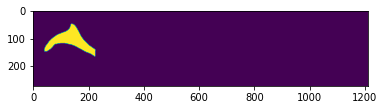

(271, 1211)


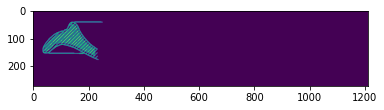

(271, 1211)


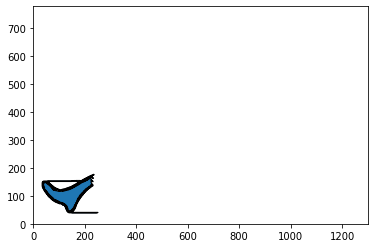

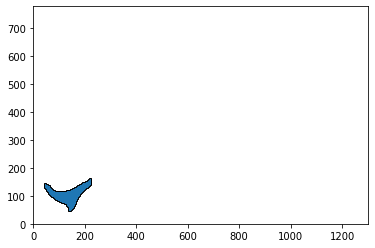

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(41.0, 127.0), (42.0, 127.0), (42.0, 128.0), (41.0, 128.0), (41.0, 127.0), (42.0, 127.0), (42.0, 126.0), (43.0, 126.0), (43.0, 127.0), (42.0, 127.0), (43.0, 126.0), (43.0, 124.0), (44.0, 124.0), (44.0, 122.0), (45.0, 122.0), (45.0, 120.0), (46.0, 120.0), (46.0, 119.0), (47.0, 119.0), (47.0, 117.0), (48.0, 117.0), (48.0, 116.0), (49.0, 116.0), (49.0, 115.0), (50.0, 115.0), (50.0, 114.0), (51.0, 114.0), (51.0, 112.0), (52.0, 112.0), (52.0, 111.0), (53.0, 111.0), (53.0, 110.0), (54.0, 110.0), (54.0, 109.0), (55.0, 109.0), (55.0, 107.0), (56.0, 107.0), (56.0, 106.0), (57.0, 106.0), (57.0, 105.0), (58.0, 105.0), (58.0, 104.0), (59.0, 104.0), (59.0, 103.0), (60.0, 103.0), (60.0, 101.0), (61.0, 101.0), (61.0, 100.0), (62.0, 100.0), (62.0, 99.0), (63.0, 99.0), (63.0, 98.0), (64.0, 98.0), (64.0, 97.0), (66.0, 97.0), (66.0, 96.0), (67.0, 96.0), (67.0, 95.0), (68.0, 95.0), (68.0, 94.0), (69.0, 94.0), (69.0,

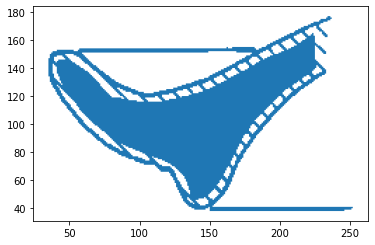

I am still a Polygon
This is the interior areasize:  1.0
This is the smallerthanarea:  328
This is the interior areasize:  1.0
This is the smallerthanarea:  328
This is the interior areasize:  216.0
This is the smallerthanarea:  328
This is the interior areasize:  1.0
This is the smallerthanarea:  328
This is the interior areasize:  36.0
This is the smallerthanarea:  328
This is the interior areasize:  68.0
This is the smallerthanarea:  328
This is the interior areasize:  1.0
This is the smallerthanarea:  328
This is the interior areasize:  1.0
This is the smallerthanarea:  328
This is the interior areasize:  115.0
This is the smallerthanarea:  328
This is the interior areasize:  35.0
This is the smallerthanarea:  328
This is the interior areasize:  23.0
This is the smallerthanarea:  328
This is the interior areasize:  212.0
This is the smallerthanarea:  328
This is the interior areasize:  34.0
This is the smallerthanarea:  328
This is the interior areasize:  68.0
This is the smallerth

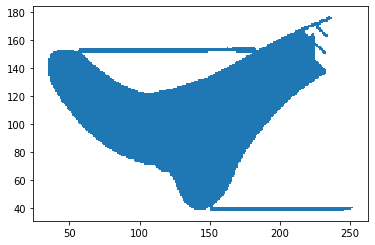

This is the Area:  12053.0
This is the Buffer  -2
This is the Area:  11190.464622820988
Only larger than this survives: 1093
I am still a Polygon
This is the Area:  11190.464622820988
                                            geometry   method          area
0  POLYGON ((35.972 134.014, 35.801 134.129, 35.6...  grabcut  11190.464623


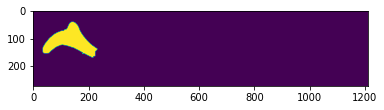

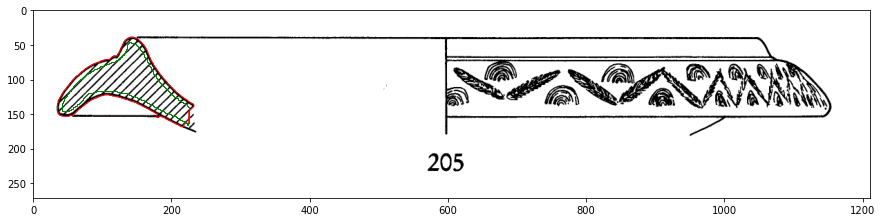

This is the segmented image: (271, 1211) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/simitthus_ed/ed5246ff-a118-41c3-932b-1ac03de537ee
<class 'numpy.ndarray'>
CountNonZero: 7911
any smalle than 255
firstkernel (94, 47)
This is the Kernel to erode the detectedmask:  (8, 8)


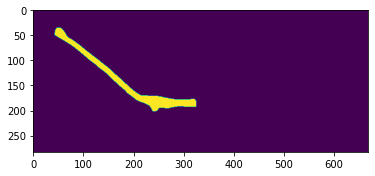

(283, 669)


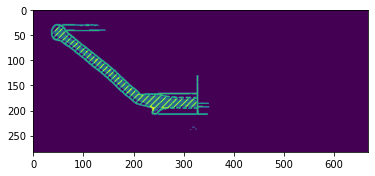

(283, 669)


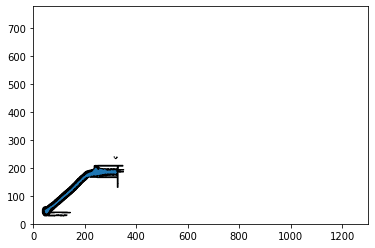

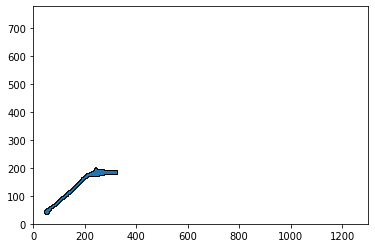

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(59.0, 38.0), (60.0, 38.0), (60.0, 37.0), (61.0, 37.0), (61.0, 38.0), (62.0, 38.0), (62.0, 41.0), (61.0, 41.0), (61.0, 40.0), (60.0, 40.0), (60.0, 39.0), (59.0, 39.0), (59.0, 38.0), (62.0, 41.0), (63.0, 41.0), (63.0, 43.0), (62.0, 43.0), (62.0, 41.0), (185.0, 146.0), (187.0, 146.0), (187.0, 147.0), (185.0, 147.0), (185.0, 146.0), (187.0, 147.0), (189.0, 147.0), (189.0, 148.0), (190.0, 148.0), (190.0, 149.0), (191.0, 149.0), (191.0, 150.0), (190.0, 150.0), (189.0, 150.0), (189.0, 149.0), (188.0, 149.0), (188.0, 148.0), (187.0, 148.0), (187.0, 147.0), (210.0, 166.0), (208.0, 166.0), (208.0, 165.0), (207.0, 165.0), (207.0, 164.0), (209.0, 164.0), (209.0, 165.0), (210.0, 165.0), (210.0, 166.0), (207.0, 164.0), (205.0, 164.0), (205.0, 163.0), (205.0, 162.0), (206.0, 162.0), (206.0, 163.0), (207.0, 163.0), (207.0, 164.0), (44.0, 41.0), (43.0, 41.0), (43.0, 42.0), (42.0, 42.0), (42.0, 43.0), (41.0, 43.0

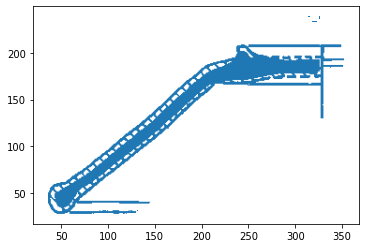

I am still a Polygon
This is the interior areasize:  7.0
This is the smallerthanarea:  189
This is the interior areasize:  2.0
This is the smallerthanarea:  189
This is the interior areasize:  2.0
This is the smallerthanarea:  189
This is the interior areasize:  6.0
This is the smallerthanarea:  189
This is the interior areasize:  4.0
This is the smallerthanarea:  189
This is the interior areasize:  3.0
This is the smallerthanarea:  189
This is the interior areasize:  71.0
This is the smallerthanarea:  189
This is the interior areasize:  28.0
This is the smallerthanarea:  189
This is the interior areasize:  13.0
This is the smallerthanarea:  189
This is the interior areasize:  30.0
This is the smallerthanarea:  189
This is the interior areasize:  16.0
This is the smallerthanarea:  189
This is the interior areasize:  19.0
This is the smallerthanarea:  189
This is the interior areasize:  24.0
This is the smallerthanarea:  189
This is the interior areasize:  15.0
This is the smallerthanar

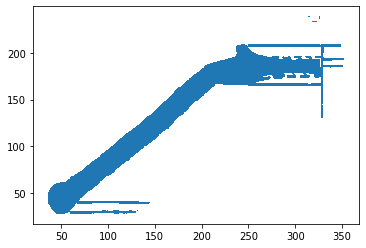

This is the Area:  9534.0
This is the Area:  3.0
This is the Area:  5.0
This is the Area:  2.0
This is the Area:  1.0
This is the Buffer  -2
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240499927024, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020988E4DB80>, '_exterior': <weakref at 0x0000020974D21AE0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240499927584, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020988E4DB80>, '_exterior': <weakref at 0x00000209A7C30A90; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240499928544, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020988E4DB80>, '_exterior': <weakref at 0x00000209AA08D4F0; dead>}
This is the Area:  19.50923774999889
This is the Area:  17.99176350583311

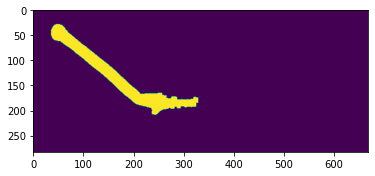

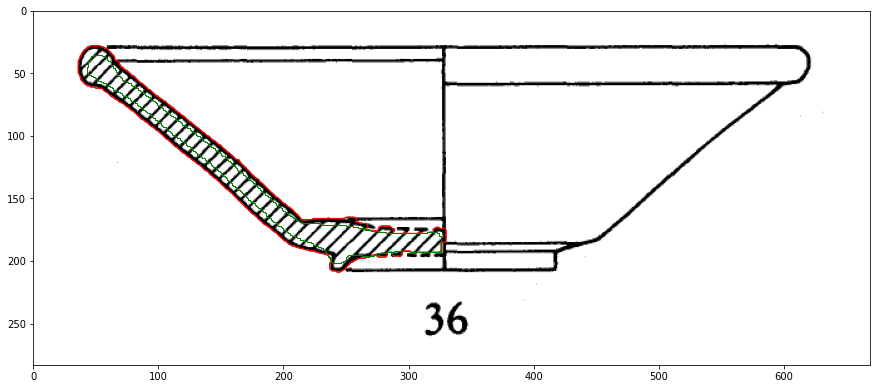

This is the segmented image: (283, 669) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/simitthus_ed/376eb85a-bb87-45d9-8d0b-f0f73b8b8d2a
<class 'numpy.ndarray'>
CountNonZero: 4463
any smalle than 255
firstkernel (110, 55)
This is the Kernel to erode the detectedmask:  (9, 9)


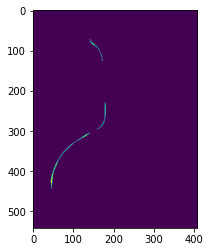

(542, 409)


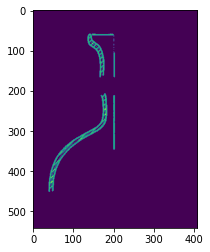

(542, 409)


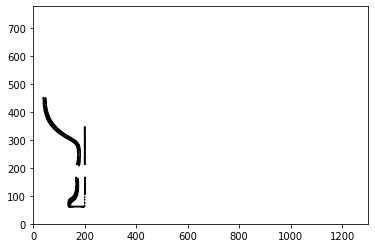

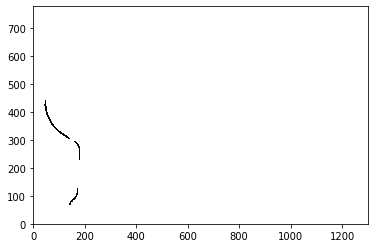

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593505632, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A7477610>, '_exterior': <weakref at 0x00000209A48E5590; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593502752, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A7477610>, '_exterior': <weakref at 0x00000209A48E5180; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593502832, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A7477610>, '_exterior': <weakref at 0x00000209A7AA8540; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593504032, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

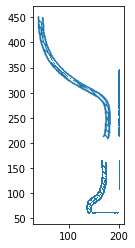

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  38.0
This is the smallerthanarea:  221
This is the interior areasize:  1.0
This is the smallerthanarea:  221
This is the interior areasize:  386.0
This is the smallerthanarea:  221
This interior will make a difference
This is the interior areasize:  1.0
This is the smallerthanarea:  221
This is the interior areasize:  1.0
This is the smallerthanarea:  221
This is the interior areasize:  1.0
This is the smallerthanarea:  221
This is the interior areasize:  1.0
This is the smallerth

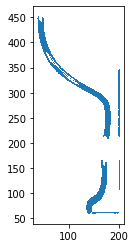

This is the Area:  182.0
This is the Area:  523.0
This is the Area:  177.0
This is the Area:  3.0
This is the Area:  7.0
This is the Area:  4.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  4.0
This is the Area:  2.0
This is the Area:  4.0
This is the Area:  4.0
This is the Area:  4.0
This is the Area:  1.0
This is the Area:  49.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  3143.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1372.0
This is the Area:  6.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Buffer  -2
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593502112, '_ndim': 2, '__p__': <shapely.geometry.base.Geometry

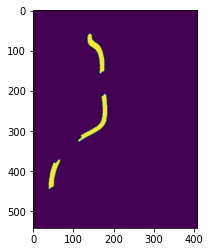

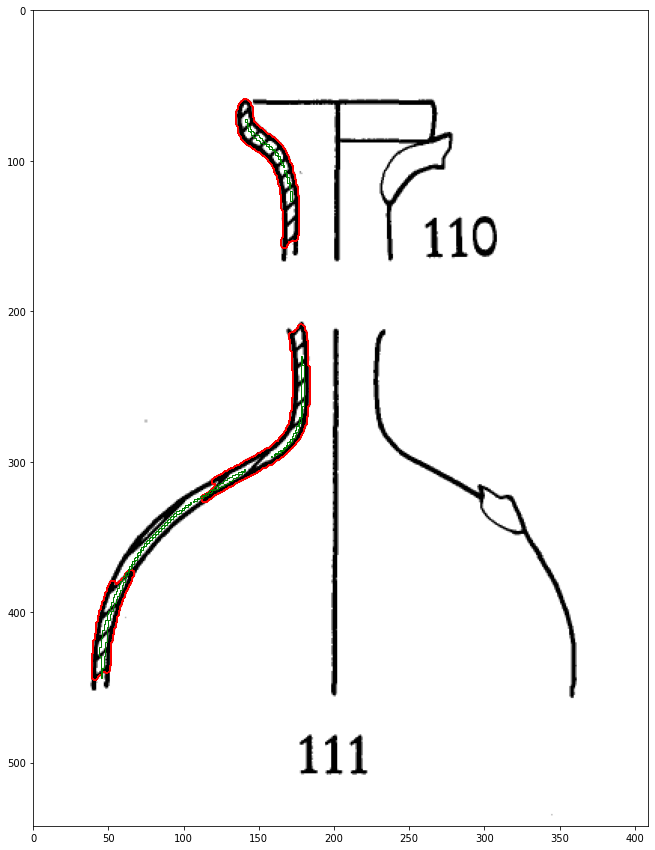

This is the segmented image: (542, 409) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/tallzira_ed/8539ce57-883e-42b8-b794-dc030660ec8c
<class 'numpy.ndarray'>
CountNonZero: 9929
any smalle than 255
firstkernel (150, 75)
This is the Kernel to erode the detectedmask:  (10, 10)


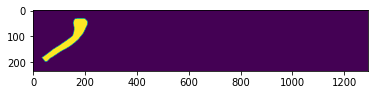

(233, 1292)


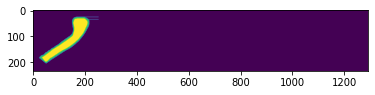

(233, 1292)


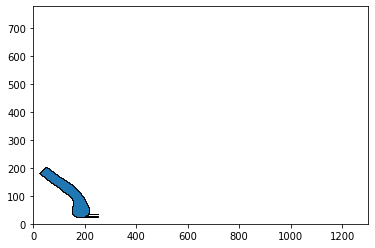

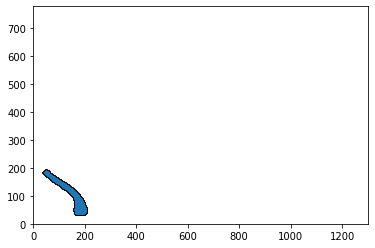

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587761472, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AAAF61F0>, '_exterior': <weakref at 0x00000209A99F0DB0; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240587740912, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AAB07D00>, '_exterior': <weakref at 0x00000209A71A5E00; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
[{'geometry': <shapely.geometry.polygon.Polygon object at 0x00000209AAB07BB0>, 'method': 'detected'}]
This is before close_holes:


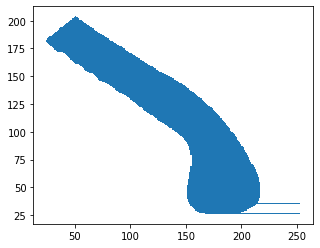

I am still a Polygon
This is after close_holes:


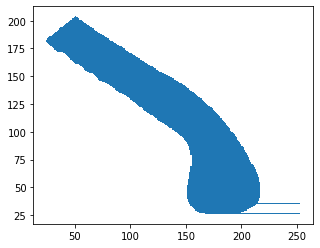

This is the Area:  10017.0
This is the Buffer  -2
This is the Area:  9807.074707238491
Only larger than this survives: 1003
I am still a Polygon
This is the Area:  9807.074707238491
                                            geometry   method         area
0  POLYGON ((24.984 182.973, 25.013 183.034, 25.1...  grabcut  9807.074707


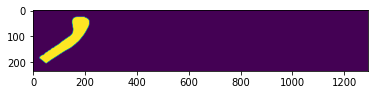

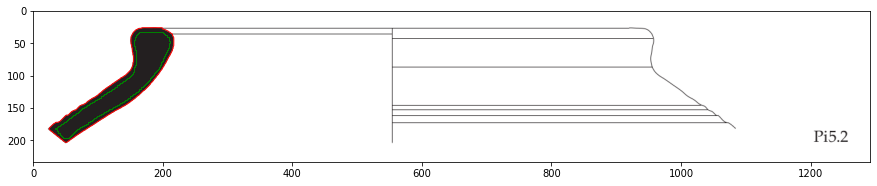

This is the segmented image: (233, 1292) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/tallzira_ed/289a1949-6f9c-46f5-90fd-9c97d71430ef
<class 'numpy.ndarray'>
CountNonZero: 17619
any smalle than 255
firstkernel (268, 134)
This is the Kernel to erode the detectedmask:  (14, 14)


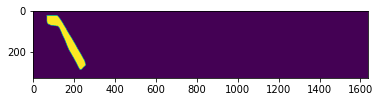

(328, 1637)


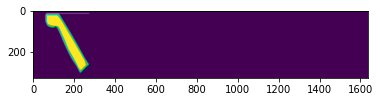

(328, 1637)


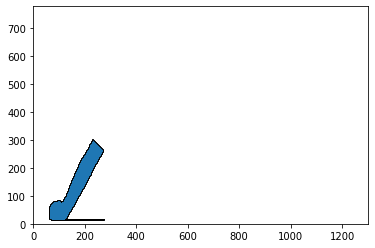

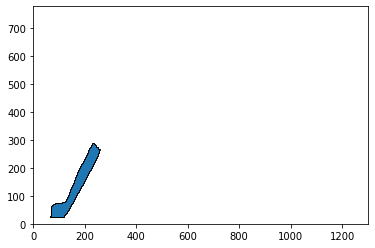

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500941040, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209A719DC40>, '_exterior': <weakref at 0x00000209AA8B41D0; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500983760, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA8118B0>, '_exterior': <weakref at 0x00000209ACD8AE00; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
[{'geometry': <shapely.geometry.polygon.Polygon object at 0x00000209AA811910>, 'method': 'detected'}]
This is before close_holes:


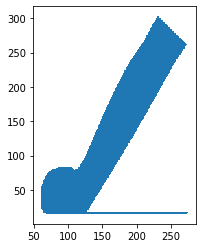

I am still a Polygon
This is after close_holes:


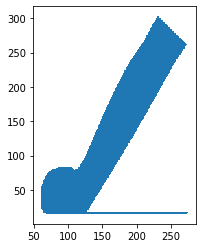

This is the Area:  18226.0
This is the Buffer  -3
This is the Area:  17721.877194384946
Only larger than this survives: 1789
I am still a Polygon
This is the Area:  17721.877194384946
                                            geometry   method          area
0  POLYGON ((60.996 24.998, 60.985 25.008, 60.788...  grabcut  17721.877194


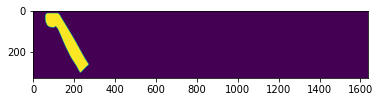

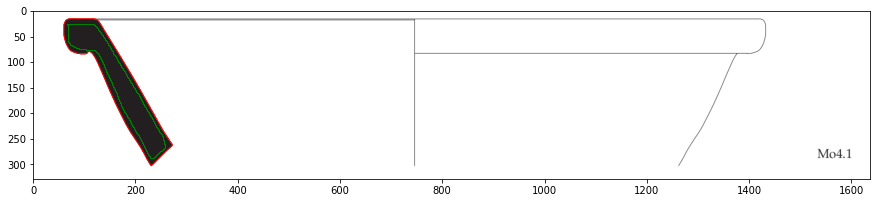

This is the segmented image: (328, 1637) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/tallzira_ed/515fc7d4-b574-4147-856c-6437b84641e9
<class 'numpy.ndarray'>
CountNonZero: 3879
any smalle than 255
firstkernel (49, 24)
This is the Kernel to erode the detectedmask:  (6, 6)


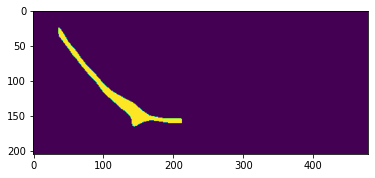

(205, 479)


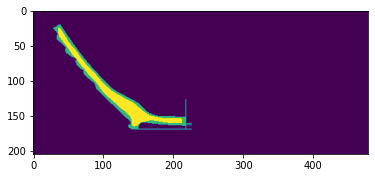

(205, 479)


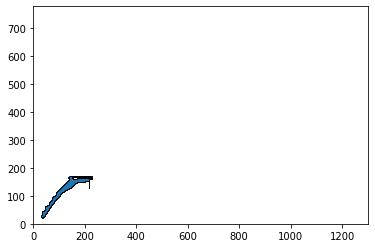

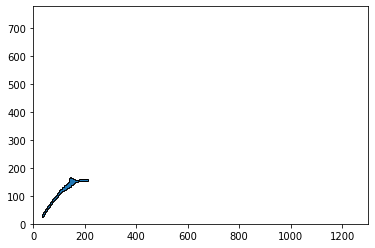

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(152.0, 163.0), (152.0, 162.0), (153.0, 162.0), (154.0, 162.0), (154.0, 161.0), (156.0, 161.0), (156.0, 160.0), (158.0, 160.0), (164.0, 160.0), (164.0, 161.0), (170.0, 161.0), (170.0, 162.0), (179.0, 162.0), (179.0, 163.0), (193.0, 163.0), (193.0, 164.0), (213.0, 164.0), (213.0, 165.0), (218.0, 165.0), (218.0, 169.0), (151.0, 169.0), (151.0, 165.0), (152.0, 165.0), (152.0, 163.0)]
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593548112, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x0000020974D973D0>, '_exterior': <weakref at 0x00000209A9A81630; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length of multi2singlepolygon resullt (grabcut):  1
Here comes detected multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240593553872, '_ndim': 2, '__p__': <shapely.

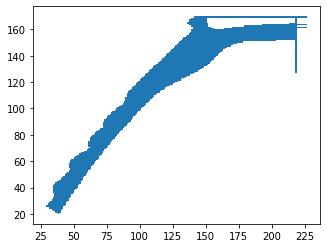

I am still a Polygon
This is the interior areasize:  421.0
This is the smallerthanarea:  98
This interior will make a difference
This is after close_holes:


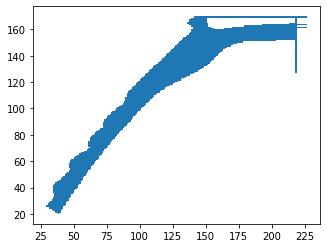

This is the Area:  4100.0
This is the Buffer  -1
This is the Area:  3926.055029372074
Only larger than this survives: 327
I am still a Polygon
This is the Area:  3926.055029372074
                                            geometry   method         area
0  POLYGON ((29.999 27.001, 30.001 27.049, 30.011...  grabcut  3926.055029


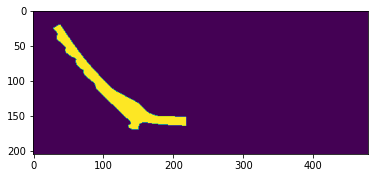

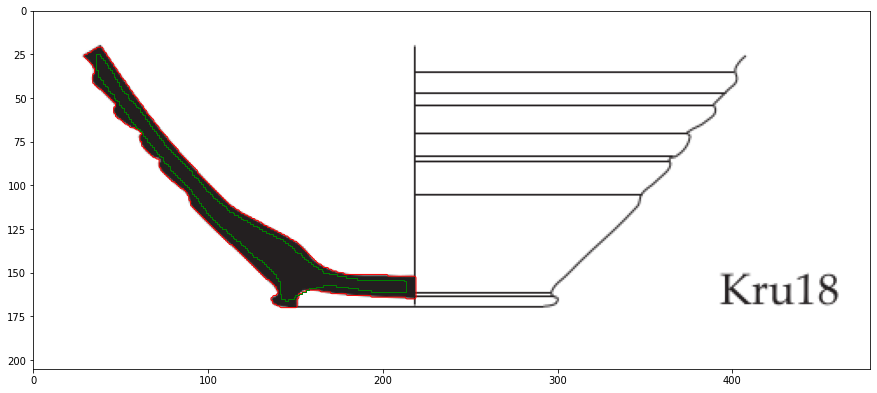

This is the segmented image: (205, 479) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/urukcatalogs_ed/7c83fba6-5ae8-4bc6-8dfc-73bab4372a0e
<class 'numpy.ndarray'>
CountNonZero: 11229
any smalle than 255
firstkernel (120, 60)
This is the Kernel to erode the detectedmask:  (9, 9)


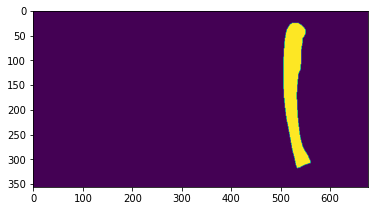

(356, 677)


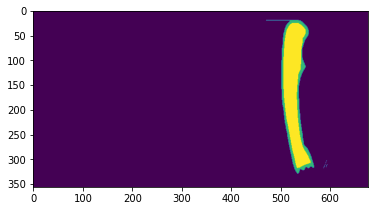

(356, 677)


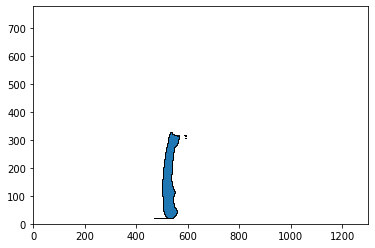

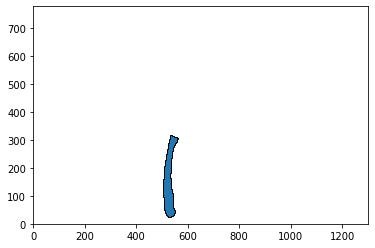

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500044272, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096B15ED90>, '_exterior': <weakref at 0x000002096B25FEA0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500046512, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096B15ED90>, '_exterior': <weakref at 0x000002096B25FE00; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500044752, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x000002096B15ED90>, '_exterior': <weakref at 0x00000209A4994DB0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240500042192, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

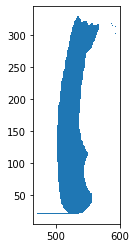

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


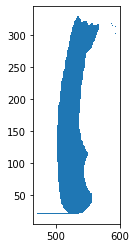

This is the Area:  1.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  11372.0
This is the Buffer  -2
This is the Area:  11247.37581996195
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 803
I am still a Polygon
This is the Area:  11247.37581996195
                                             geometry   method         area
10  POLYGON ((502.998 100.999, 502.972 101.014, 50...  grabcut  11247.37582


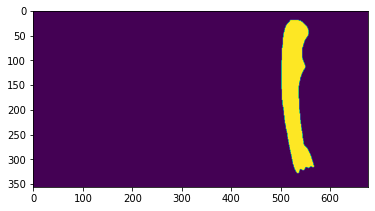

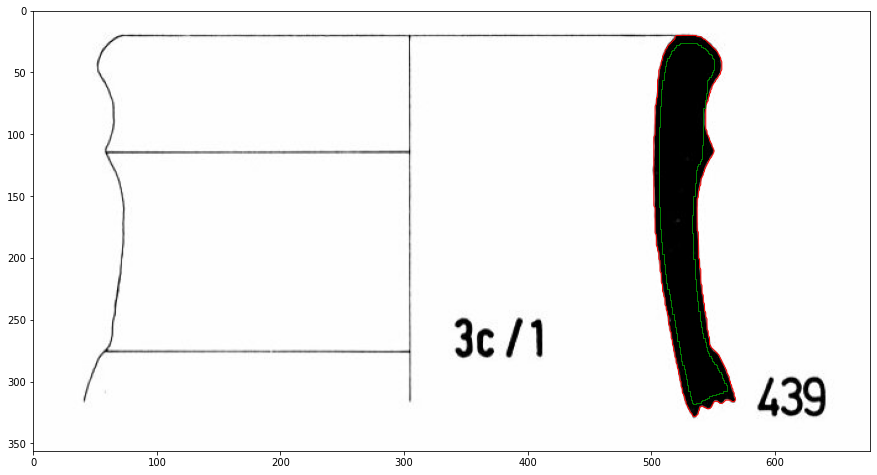

This is the segmented image: (356, 677) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/urukcatalogs_ed/b862c005-2d56-4b44-bc71-8340034ec3f8
<class 'numpy.ndarray'>
CountNonZero: 11868
any smalle than 255
firstkernel (52, 26)
This is the Kernel to erode the detectedmask:  (6, 6)


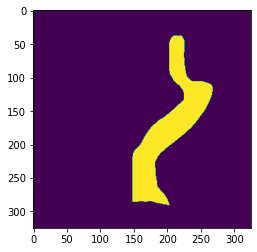

(325, 325)


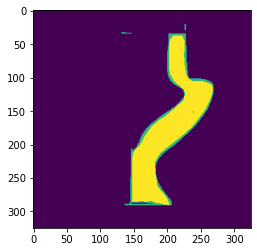

(325, 325)


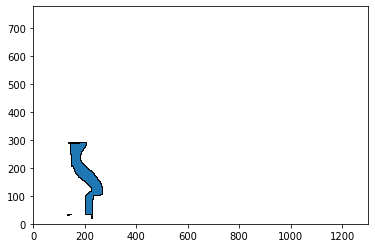

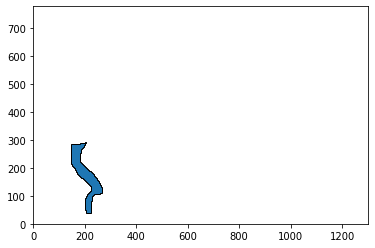

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: [(147.0, 287.0), (169.0, 287.0), (169.0, 288.0), (178.0, 288.0), (178.0, 289.0), (147.0, 289.0), (147.0, 287.0)]
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497765808, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA8649A0>, '_exterior': <weakref at 0x00000209A9D0AEF0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497763648, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA8649A0>, '_exterior': <weakref at 0x00000209A9D0A9A0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240497762128, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA8649A0>, '_exterior': <weakref at 0x00000209A7720E00; dead>}
What kind of Geomerty are you? Answer:  MultiPolygon
This is the length

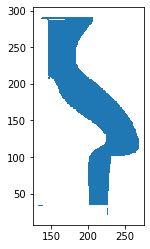

I am still a Polygon
This is the interior areasize:  53.0
This is the smallerthanarea:  105
I am still a Polygon
I am still a Polygon
This is after close_holes:


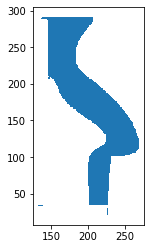

This is the Area:  11749.0
This is the Area:  18.0
This is the Area:  21.0
This is the Buffer  -1
This is the Area:  11684.037628266658
This is the Area:  0.0
This is the Area:  0.0
Only larger than this survives: 352
I am still a Polygon
This is the Area:  11684.037628266658
                                            geometry   method          area
0  POLYGON ((143.951 289.001, 143.855 289.011, 14...  grabcut  11684.037628


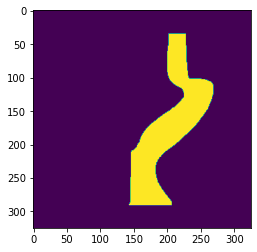

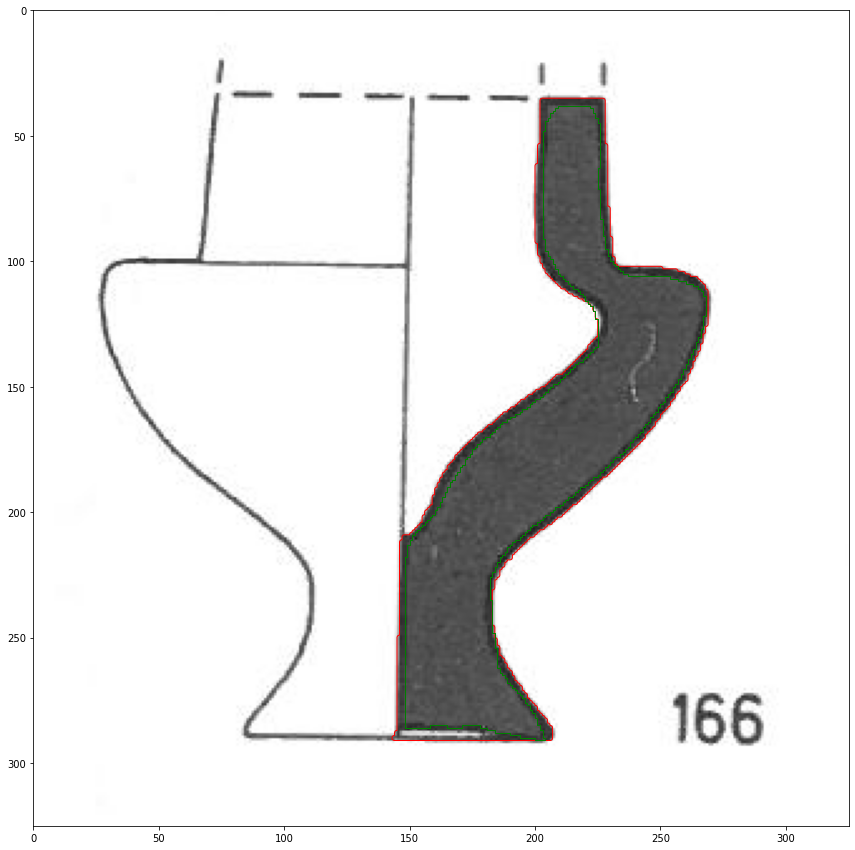

This is the segmented image: (325, 325) <class 'numpy.ndarray'>
Compute feature vectors
E:/mining_shapes/imagestore/urukcatalogs_ed/f8c49772-af68-4e08-9b38-5cf30dd23bcd
<class 'numpy.ndarray'>
CountNonZero: 23579
any smalle than 255
firstkernel (180, 90)
This is the Kernel to erode the detectedmask:  (12, 12)


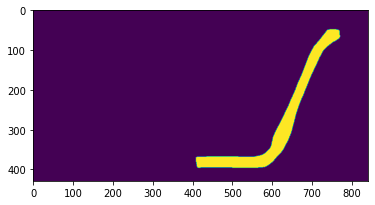

(429, 841)


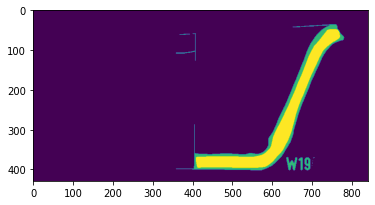

(429, 841)


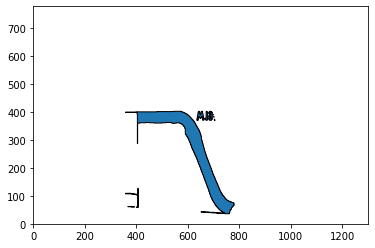

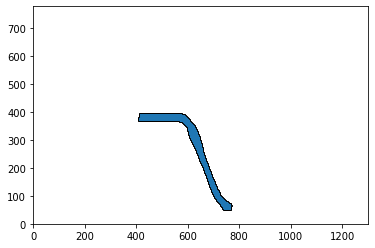

Here comes grabcut multi2single:
I am Multipolygon
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240505964992, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA7E8760>, '_exterior': <weakref at 0x00000209A7C9F3B0; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240505968352, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA7E8760>, '_exterior': <weakref at 0x00000209A9E0AB80; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240505966912, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object at 0x00000209AA7E8760>, '_exterior': <weakref at 0x00000209A9FAC900; dead>}
This is the interiors of multi2single: []
{'_other_owned': True, '_is_empty': False, '__geom__': 2240505966992, '_ndim': 2, '__p__': <shapely.geometry.base.GeometrySequence object a

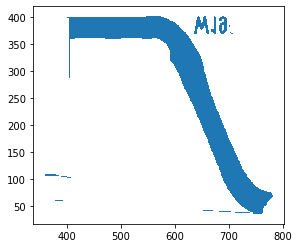

I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is the interior areasize:  40.0
This is the smallerthanarea:  360
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
I am still a Polygon
This is after close_holes:


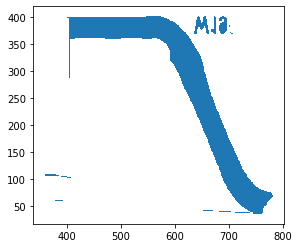

This is the Area:  23707.0
This is the Area:  1.0
This is the Area:  3.0
This is the Area:  1.0
This is the Area:  2.0
This is the Area:  1.0
This is the Area:  362.0
This is the Area:  182.0
This is the Area:  28.0
This is the Area:  470.0
This is the Area:  159.0
This is the Area:  31.0
This is the Buffer  -3
This is the Area:  23248.69289877545
This is the Area:  274.50517014981784
This is the Area:  256.9173415295801
This is the Area:  57.15300885579409
This is the Area:  0.0
Only larger than this survives: 1202
I am still a Polygon
This is the Area:  23248.69289877545
                                            geometry   method          area
0  POLYGON ((404.000 397.000, 404.014 397.294, 40...  grabcut  23248.692899


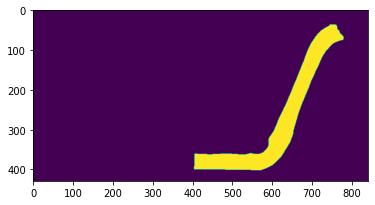

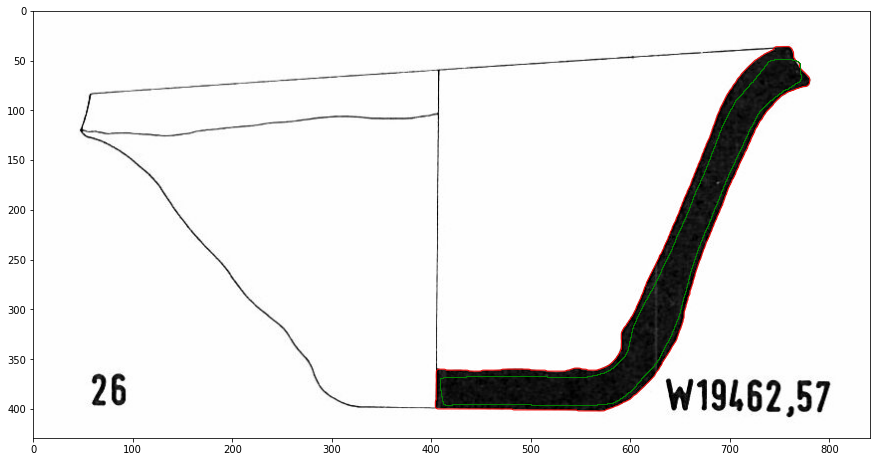

This is the segmented image: (429, 841) <class 'numpy.ndarray'>
Compute feature vectors


In [50]:
%matplotlib inline
selectlist = ['lattara6_edv2', 'sidikhrebish_ed','simitthus_ed','althiburos_ed']
selectlist50 = ['althiburos_ed','lattara6_edv2', 'sidikhrebish_ed','simitthus_ed','bonifay2004_ed', 'hayes1972_edv2', 'sabratha_ed', 'tallzira_ed']
outputpath = Path("E:/mining_shapes/segmented_profiles/")
#vessel_image_list = []
taskname = 'ImproveMaskTrain2'
labelmappath =  Path("E:/Traindata/Trainingdata_fromCVAT/profile_segmentation/voc/labelmap.txt")


#for db_name in list:
    #data_path = imagestore + db_name +'/'
    #vessel_image_list_db = selectimages(3)
    #
    #vessel_image_list = vessel_image_list + vessel_image_list_db

originalimagesfolder, taskfolder, subsettextfile, segmentclassfolder, segmentobjectfolder = createVOCfolder(outputpath, taskname,labelmappath)
#print(vocfolder)
for vessel in vessel_image_list:
    #print(vessel)
    original_img, segmented_img = process_files(vessel)
    addToVOCfolder(original_img, segmented_img)
    print("Compute feature vectors")
    drawingID = os.path.basename(vessel)
    db_name = os.path.dirname(vessel)
    resnetfeatures = compute_resnet_featurevector(segmented_img)
    print(resnetfeatures)
    #fourierfeatures = compute_fourier_featurevector(segmented_img)